In [8]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install pystan==2.19.1.1

Note: you may need to restart the kernel to use updated packages.


In [10]:
!pip install fbprophet

In [156]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import plotly.graph_objects as go
import plotly.express as px

import matplotlib.pyplot as plt

sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
cmaps_hex = ['#193251','#FF5A36','#1E4485', '#99D04A','#FF5A36', '#DB6668']
sns.set_palette(palette=cmaps_hex)
sns_c = sns.color_palette(palette=cmaps_hex)

from scipy.ndimage import gaussian_filter

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller,kpss
import statsmodels.api as sm
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf,pacf
from fbprophet import Prophet
from sklearn.metrics import make_scorer









plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

# Data Cleaning

In [12]:
df_train = pd.read_csv('data/train.csv')
train_data= df_train
df_test = pd.read_csv('data/test.csv')
df_store = pd.read_csv('data/store.csv')

In [13]:
df_train.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1

In [14]:
# Merge df_store and df_train
df = df_train.merge(df_store, how='left', left_on=df_train.Store, right_on=df_store.Store)
df.drop(['key_0', 'Store_y'], axis=1, inplace=True)
df = df.rename(columns={'Store_x':'Store'})
df.shape

(1017209, 18)

In [15]:
df.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  \
0              1         c          a               1270.0   
1              1         a          a                570.0   
2              1         a          a              14130.0   
3              1         c          c                620.0   
4              1         a          a              29910.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1                       11.0                    2007.0       1   
2                       12.0                    2006.0       1   
3                        9.0                    2009.0       0   
4                        4.0                    2015.0       0   

   Promo2SinceWeek  Promo2SinceYear    PromoInterval  
0              NaN              NaN              NaN  
1             13.0           2010.0  Jan,Apr,Jul,Oct  
2             14.0           2011.0  Jan,Apr,Jul,Oct  
3              NaN              NaN              NaN  
4              NaN              NaN              NaN

In [16]:
cols = df.columns.tolist()
cols = [col.lower() for col in cols]
df.columns = cols

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   store                      1017209 non-null  int64  
 1   dayofweek                  1017209 non-null  int64  
 2   date                       1017209 non-null  object 
 3   sales                      1017209 non-null  int64  
 4   customers                  1017209 non-null  int64  
 5   open                       1017209 non-null  int64  
 6   promo                      1017209 non-null  int64  
 7   stateholiday               1017209 non-null  object 
 8   schoolholiday              1017209 non-null  int64  
 9   storetype                  1017209 non-null  object 
 10  assortment                 1017209 non-null  object 
 11  competitiondistance        1014567 non-null  float64
 12  competitionopensincemonth  693861 non-null   float64
 13  competitiono

In [18]:
df = df.assign(
    timestamp = lambda x: pd.to_datetime(x['date']),
    year = lambda x: x['timestamp'].dt.year,
    month = lambda x: x['timestamp'].dt.month,
    day = lambda x: x['timestamp'].dt.day,
    dayofyear = lambda x: x['timestamp'].dt.dayofyear
)

In [19]:
df_test = df_test.assign(
    timestamp = lambda x: pd.to_datetime(x['Date']),
    year = lambda x: x['timestamp'].dt.year,
    month = lambda x: x['timestamp'].dt.month,
    day = lambda x: x['timestamp'].dt.day,
    dayofyear = lambda x: x['timestamp'].dt.dayofyear
)

In [20]:
train_data = train_data.assign(
    timestamp = lambda x: pd.to_datetime(x['Date']),
    year = lambda x: x['timestamp'].dt.year,
    month = lambda x: x['timestamp'].dt.month,
    day = lambda x: x['timestamp'].dt.day,
    dayofyear = lambda x: x['timestamp'].dt.dayofyear
)

In [21]:
df.head()

store  dayofweek        date  sales  customers  open  promo stateholiday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   schoolholiday storetype  ... competitionopensinceyear  promo2  \
0              1         c  ...                   2008.0       0   
1              1         a  ...                   2007.0       1   
2              1         a  ...                   2006.0       1   
3              1         c  ...                   2009.0       0   
4              1         a  ...                   2015.0       0   

   promo2sinceweek  promo2sinceyear    promointerval  timestamp  year month  \
0              NaN              NaN              NaN 2015-07-31  2015     7   
1             13.0           2010.0  Jan,Apr,Jul,Oct 2015-07-31  2015     7   
2             14.0           2011.0  Jan,Apr,Jul,Oct 2015-07-31  2015     7   
3              NaN              NaN              NaN 2015-07-31  2015     7   
4              NaN              NaN              NaN 2015-07-31  2015     7   

  day  dayofyear  
0  31        212  
1  31        212  
2  31        212  
3  31        212  
4  31        212  

[5 rows x 23 columns]

In [22]:
df['stateholiday'].unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

In [23]:
df.stateholiday.value_counts()

0    855087
0    131072
a     20260
b      6690
c      4100
Name: stateholiday, dtype: int64

In [24]:
df['stateholiday'].replace({0:'0'}, inplace=True)

In [25]:
df.stateholiday.value_counts()

0    986159
a     20260
b      6690
c      4100
Name: stateholiday, dtype: int64

In [26]:
round(df.describe().T,2)

count     mean      std     min     25%  \
store                      1017209.0   558.43   321.91     1.0   280.0   
dayofweek                  1017209.0     4.00     2.00     1.0     2.0   
sales                      1017209.0  5773.82  3849.93     0.0  3727.0   
customers                  1017209.0   633.15   464.41     0.0   405.0   
open                       1017209.0     0.83     0.38     0.0     1.0   
promo                      1017209.0     0.38     0.49     0.0     0.0   
schoolholiday              1017209.0     0.18     0.38     0.0     0.0   
competitiondistance        1014567.0  5430.09  7715.32    20.0   710.0   
competitionopensincemonth   693861.0     7.22     3.21     1.0     4.0   
competitionopensinceyear    693861.0  2008.69     5.99  1900.0  2006.0   
promo2                     1017209.0     0.50     0.50     0.0     0.0   
promo2sinceweek             509178.0    23.27    14.10     1.0    13.0   
promo2sinceyear             509178.0  2011.75     1.66  2009.0  2011.0   
year                       1017209.0  2013.83     0.78  2013.0  2013.0   
month                      1017209.0     5.85     3.33     1.0     3.0   
day                        1017209.0    15.70     8.79     1.0     8.0   
dayofyear                  1017209.0   162.28   101.62     1.0    77.0   

                              50%     75%      max  
store                       558.0   838.0   1115.0  
dayofweek                     4.0     6.0      7.0  
sales                      5744.0  7856.0  41551.0  
customers                   609.0   837.0   7388.0  
open                          1.0     1.0      1.0  
promo                         0.0     1.0      1.0  
schoolholiday                 0.0     0.0      1.0  
competitiondistance        2330.0  6890.0  75860.0  
competitionopensincemonth     8.0    10.0     12.0  
competitionopensinceyear   2010.0  2013.0   2015.0  
promo2                        1.0     1.0      1.0  
promo2sinceweek              22.0    37.0     50.0  
promo2sinceyear            2012.0  2013.0   2015.0  
year                       2014.0  2014.0   2015.0  
month                         6.0     8.0     12.0  
day                          16.0    23.0     31.0  
dayofyear                   153.0   241.0    365.0

### Handling NaN's

In [27]:
df.isnull().sum()

store                             0
dayofweek                         0
date                              0
sales                             0
customers                         0
open                              0
promo                             0
stateholiday                      0
schoolholiday                     0
storetype                         0
assortment                        0
competitiondistance            2642
competitionopensincemonth    323348
competitionopensinceyear     323348
promo2                            0
promo2sinceweek              508031
promo2sinceyear              508031
promointerval                508031
timestamp                         0
year                              0
month                             0
day                               0
dayofyear                         0
dtype: int64

In [28]:
df_store[pd.isnull(df_store.CompetitionDistance)]

Store StoreType Assortment  CompetitionDistance  \
290    291         d          a                  NaN   
621    622         a          c                  NaN   
878    879         d          a                  NaN   

     CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
290                        NaN                       NaN       0   
621                        NaN                       NaN       0   
878                        NaN                       NaN       1   

     Promo2SinceWeek  Promo2SinceYear    PromoInterval  
290              NaN              NaN              NaN  
621              NaN              NaN              NaN  
878              5.0           2013.0  Feb,May,Aug,Nov

In [29]:
# fill NaN with a median value
df['competitiondistance'].fillna(df['competitiondistance'].median(), inplace = True)
df['competitiondistance'].isnull().sum()

0

In [30]:
tmp = df_store[pd.isnull(df_store.CompetitionOpenSinceYear  )]
tmp[tmp.CompetitionDistance != 0].shape

(354, 10)

In [31]:
tmp = df[pd.isnull(df.promo2sinceweek)]
tmp[tmp.promo2 != 0].shape

(0, 23)

In [32]:
# replace NA's by 0
df.fillna(0, inplace = True)

In [33]:
df.isnull().sum()

store                        0
dayofweek                    0
date                         0
sales                        0
customers                    0
open                         0
promo                        0
stateholiday                 0
schoolholiday                0
storetype                    0
assortment                   0
competitiondistance          0
competitionopensincemonth    0
competitionopensinceyear     0
promo2                       0
promo2sinceweek              0
promo2sinceyear              0
promointerval                0
timestamp                    0
year                         0
month                        0
day                          0
dayofyear                    0
dtype: int64

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 23 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   store                      1017209 non-null  int64         
 1   dayofweek                  1017209 non-null  int64         
 2   date                       1017209 non-null  object        
 3   sales                      1017209 non-null  int64         
 4   customers                  1017209 non-null  int64         
 5   open                       1017209 non-null  int64         
 6   promo                      1017209 non-null  int64         
 7   stateholiday               1017209 non-null  object        
 8   schoolholiday              1017209 non-null  int64         
 9   storetype                  1017209 non-null  object        
 10  assortment                 1017209 non-null  object        
 11  competitiondistance        1017209 no

In [35]:
df_test.isnull().sum()

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
timestamp         0
year              0
month             0
day               0
dayofyear         0
dtype: int64

In [36]:
df_test[df_test["Open"].isnull()]

Id  Store  DayOfWeek        Date  Open  Promo StateHoliday  \
479      480    622          4  2015-09-17   NaN      1            0   
1335    1336    622          3  2015-09-16   NaN      1            0   
2191    2192    622          2  2015-09-15   NaN      1            0   
3047    3048    622          1  2015-09-14   NaN      1            0   
4759    4760    622          6  2015-09-12   NaN      0            0   
5615    5616    622          5  2015-09-11   NaN      0            0   
6471    6472    622          4  2015-09-10   NaN      0            0   
7327    7328    622          3  2015-09-09   NaN      0            0   
8183    8184    622          2  2015-09-08   NaN      0            0   
9039    9040    622          1  2015-09-07   NaN      0            0   
10751  10752    622          6  2015-09-05   NaN      0            0   

       SchoolHoliday  timestamp  year  month  day  dayofyear  
479                0 2015-09-17  2015      9   17        260  
1335               0 2015-09-16  2015      9   16        259  
2191               0 2015-09-15  2015      9   15        258  
3047               0 2015-09-14  2015      9   14        257  
4759               0 2015-09-12  2015      9   12        255  
5615               0 2015-09-11  2015      9   11        254  
6471               0 2015-09-10  2015      9   10        253  
7327               0 2015-09-09  2015      9    9        252  
8183               0 2015-09-08  2015      9    8        251  
9039               0 2015-09-07  2015      9    7        250  
10751              0 2015-09-05  2015      9    5        248

In [37]:
df_test.fillna(1, inplace=True)

In [38]:
df_test.isnull().sum()

Id               0
Store            0
DayOfWeek        0
Date             0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
timestamp        0
year             0
month            0
day              0
dayofyear        0
dtype: int64

### Handling Datatyp

In [39]:
df_test["Open"]= df_test["Open"].astype(int)

In [40]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             41088 non-null  int64         
 1   Store          41088 non-null  int64         
 2   DayOfWeek      41088 non-null  int64         
 3   Date           41088 non-null  object        
 4   Open           41088 non-null  int64         
 5   Promo          41088 non-null  int64         
 6   StateHoliday   41088 non-null  object        
 7   SchoolHoliday  41088 non-null  int64         
 8   timestamp      41088 non-null  datetime64[ns]
 9   year           41088 non-null  int64         
 10  month          41088 non-null  int64         
 11  day            41088 non-null  int64         
 12  dayofyear      41088 non-null  int64         
dtypes: datetime64[ns](1), int64(10), object(2)
memory usage: 4.1+ MB


In [41]:
train_data["StateHoliday"].unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

### Handling Categorical Data

In [42]:
le = LabelEncoder()

In [43]:
ass_typ = pd.get_dummies(df["assortment"], drop_first=True)
df = pd.concat([df,ass_typ], axis=1)


In [44]:
df["storetype_cat"] = le.fit_transform(df["storetype"])

In [45]:
df["stateholiday_cat"] = le.fit_transform(df["stateholiday"])

In [46]:
df_test["StateHoliday_cat"] = le.fit_transform(df_test["StateHoliday"])

In [47]:
train_data['StateHoliday'].replace({0:'0'}, inplace=True)

In [48]:
train_data["StateHoliday_cat"] = le.fit_transform(train_data["StateHoliday"])

In [49]:
df =df.rename(columns={"b" : "ass_extra"})

In [50]:
df =df.rename(columns={"c" : "ass_extended"})

In [51]:
df["stateholiday_cat"].unique()

array([0, 1, 2, 3])

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 27 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   store                      1017209 non-null  int64         
 1   dayofweek                  1017209 non-null  int64         
 2   date                       1017209 non-null  object        
 3   sales                      1017209 non-null  int64         
 4   customers                  1017209 non-null  int64         
 5   open                       1017209 non-null  int64         
 6   promo                      1017209 non-null  int64         
 7   stateholiday               1017209 non-null  object        
 8   schoolholiday              1017209 non-null  int64         
 9   storetype                  1017209 non-null  object        
 10  assortment                 1017209 non-null  object        
 11  competitiondistance        1017209 no

In [53]:
df.stateholiday.value_counts()

0    986159
a     20260
b      6690
c      4100
Name: stateholiday, dtype: int64

In [54]:
df.stateholiday_cat.value_counts()

0    986159
1     20260
2      6690
3      4100
Name: stateholiday_cat, dtype: int64

# Eda

## Question: Are the Promos effective?

In [55]:
df.groupby('storetype')['sales'].describe()

count          mean          std  min     25%     50%       75%  \
storetype                                                                       
a          551627.0   5738.179710  3964.028134  0.0  3508.0  5618.0   7860.00   
b           15830.0  10058.837334  5280.525506  0.0  6227.0  9025.5  13082.75   
c          136840.0   5723.629246  3721.700886  0.0  3789.0  5766.0   7849.00   
d          312912.0   5641.819243  3473.393781  0.0  3986.0  5826.0   7691.00   

               max  
storetype           
a          41551.0  
b          38722.0  
c          31448.0  
d          38037.0

In [56]:
df.groupby('storetype')['customers', 'sales'].sum()

customers       sales
storetype                       
a          363541434  3165334859
b           31465621   159231395
c           92129705   783221426
d          156904995  1765392943

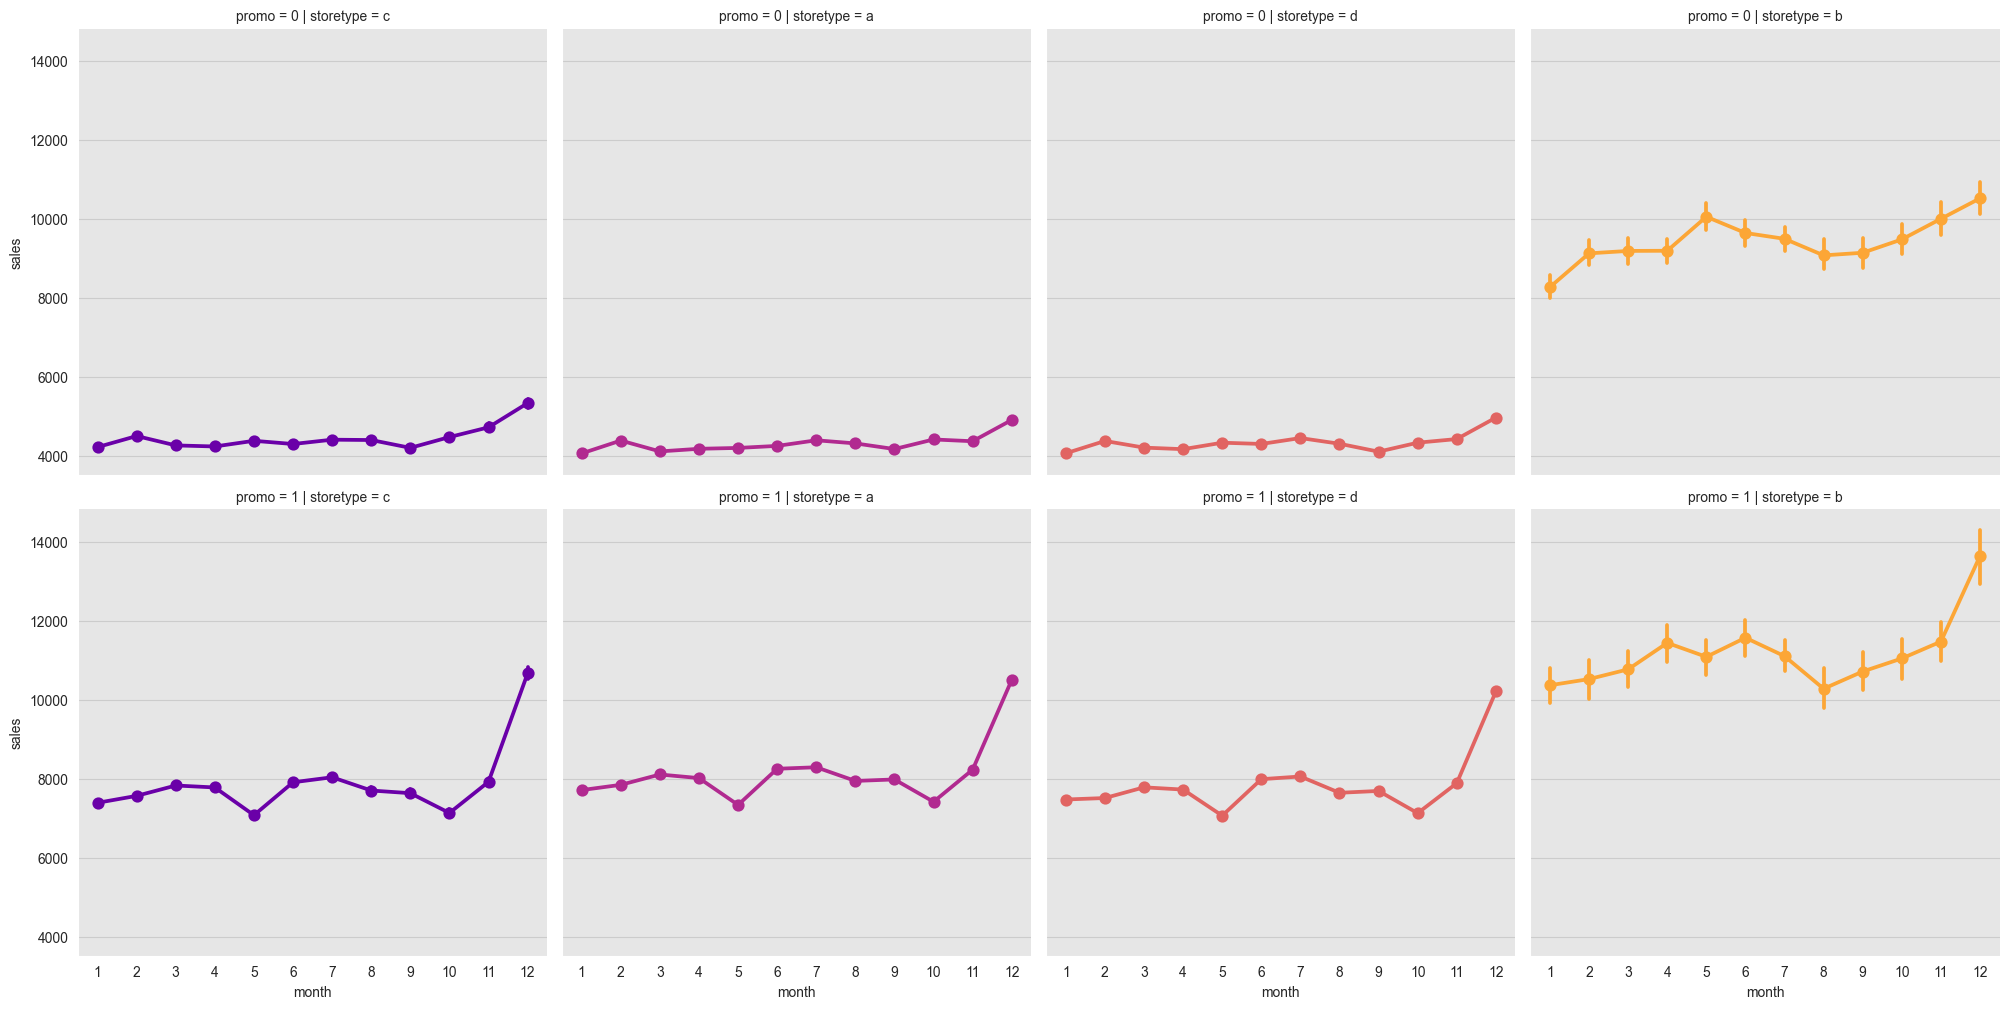

In [57]:
# sales trends
sns.factorplot(data = df, x = 'month', y = "sales", 
               col = 'storetype',
               palette = 'plasma',
               hue = 'storetype',
               row = 'promo', 
               ) 

## Finding

Storetype B has the highest sales numbers, with the largest variance. All storetypes show increased sales numbers towards christmas. 

Stores which have run a promo, show higher sales. But storetypes a,c and d show a dip towards easter, if they have run a promo, which is not the case for stores without a promo.

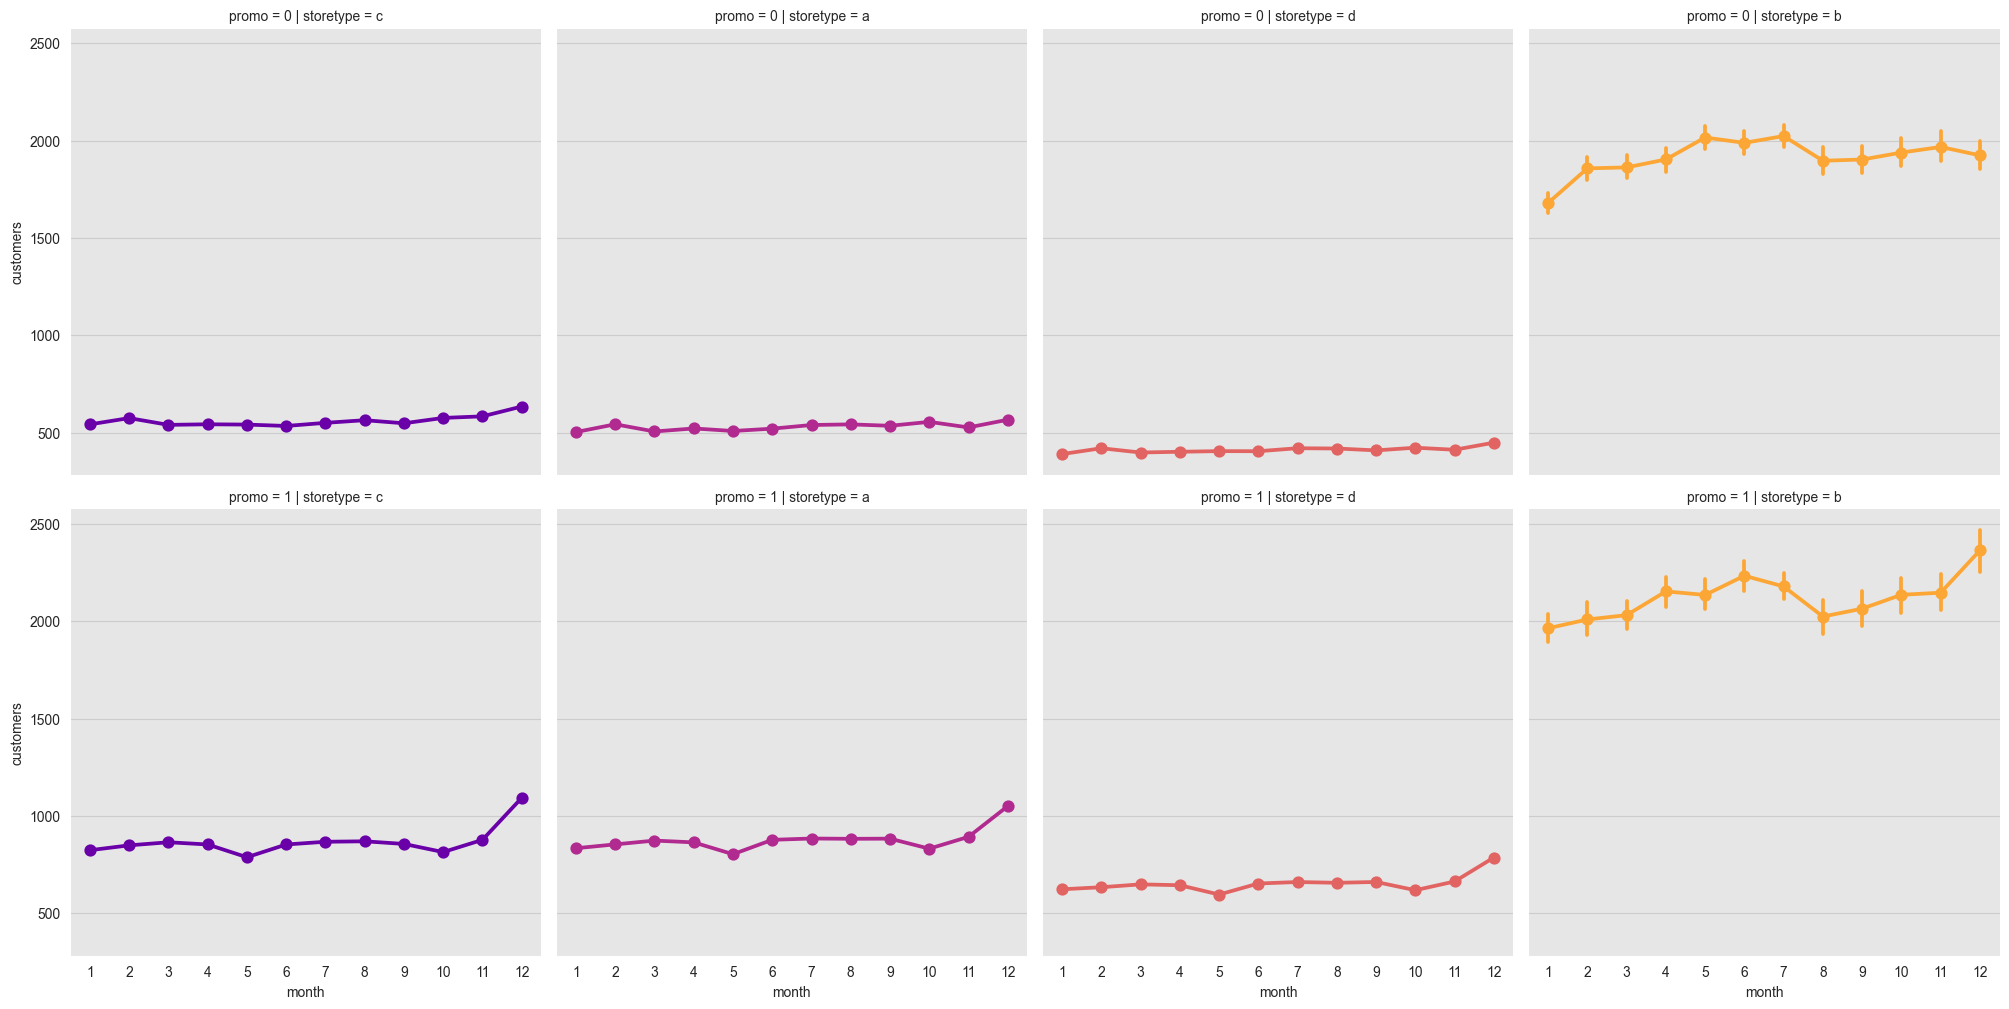

In [58]:
# customers trends
sns.factorplot(data = df, x = 'month', y = "customers", 
               col = 'storetype',
               palette = 'plasma',
               hue = 'storetype',
               row = 'promo',
               ) 

## Finding

Storetype B has the highest number of customers, with the largest variance. All storetypes show an increase of customers towards christmas. This trend is higher, if they have run a promo.

Same effect of a dip for storetypes a,c and d in customers towards easter can be also be seen here.

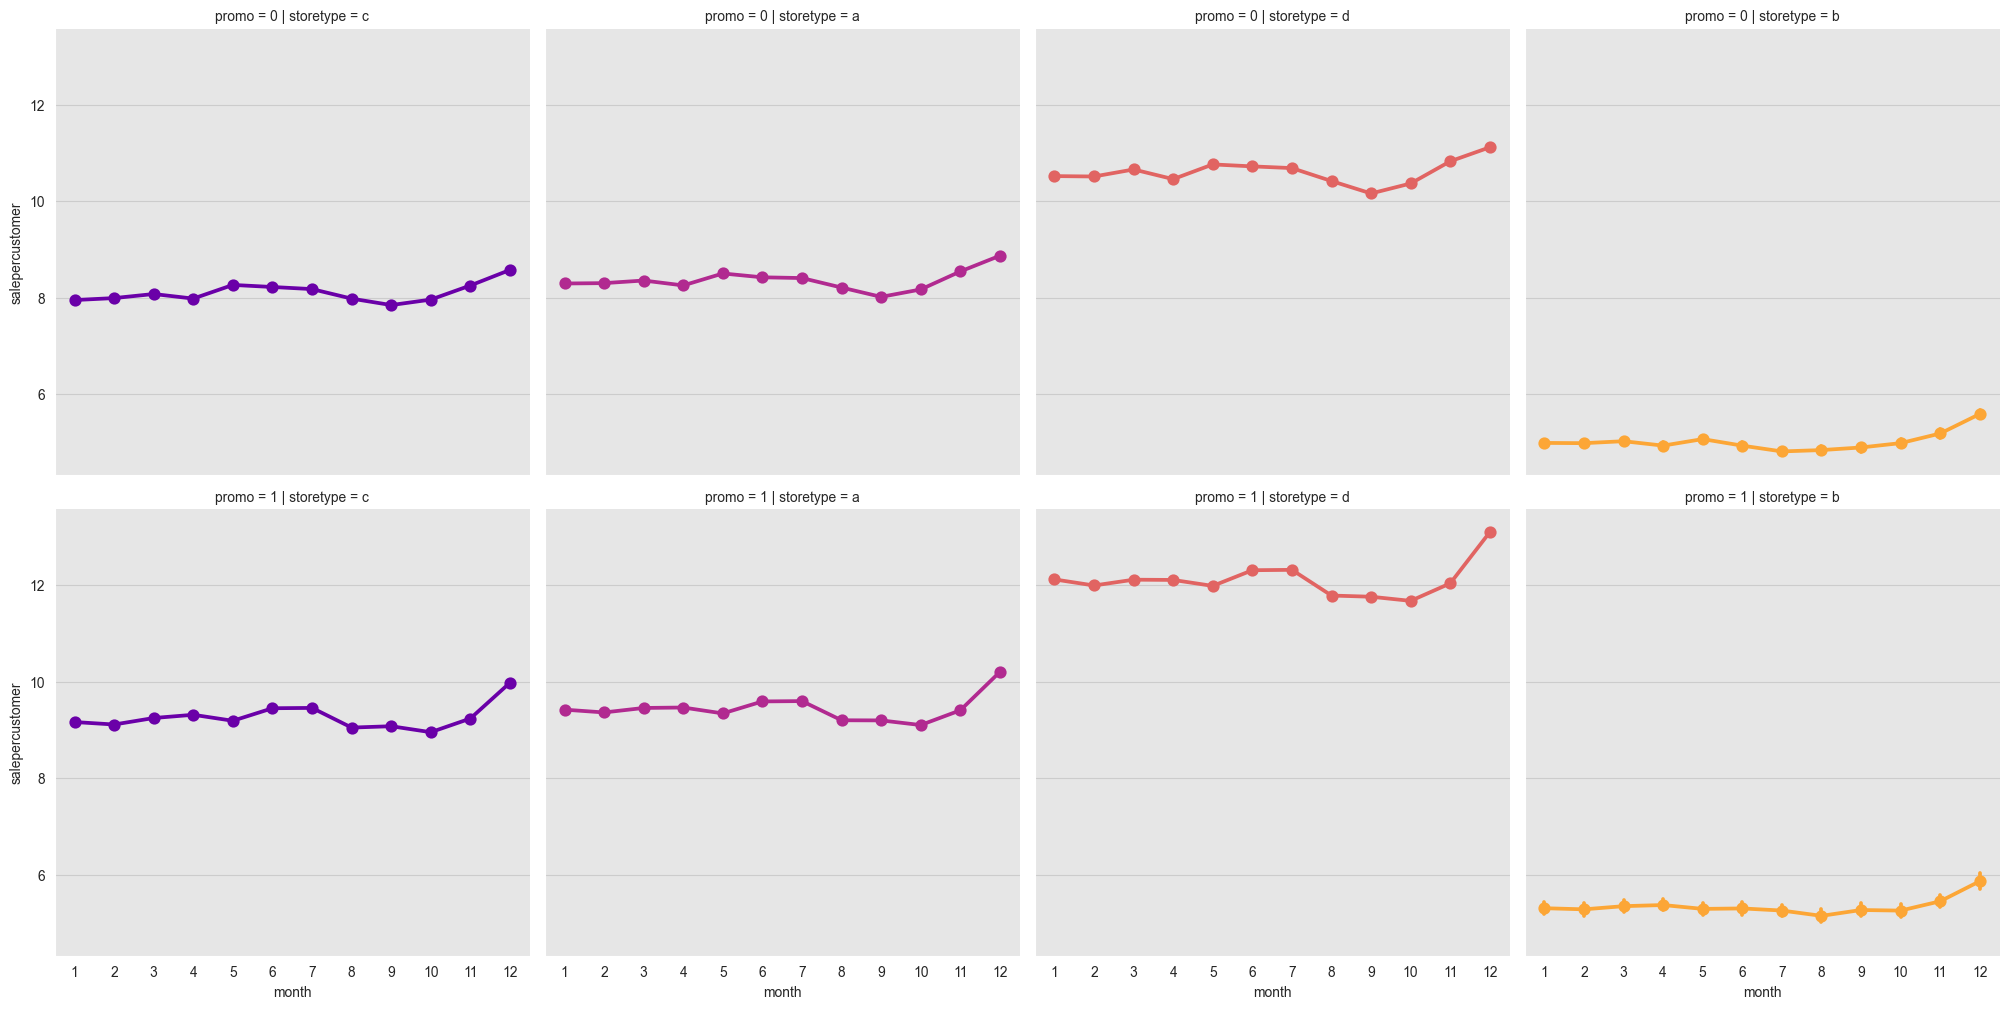

In [59]:
# sale per customer trends
df['salepercustomer'] = df['sales']/df['customers']
sns.factorplot(data = df, x = 'month', y = "salepercustomer", 
               col = 'storetype',
               palette = 'plasma',
               hue = 'storetype',
               row = 'promo', 
               ) 

## Finding

Sales per customer:
storetype b seems to be where customers only buy small items in low numbers (possible trainstation location?)
storetype d customers buy the largest quantity
a und c are very similar

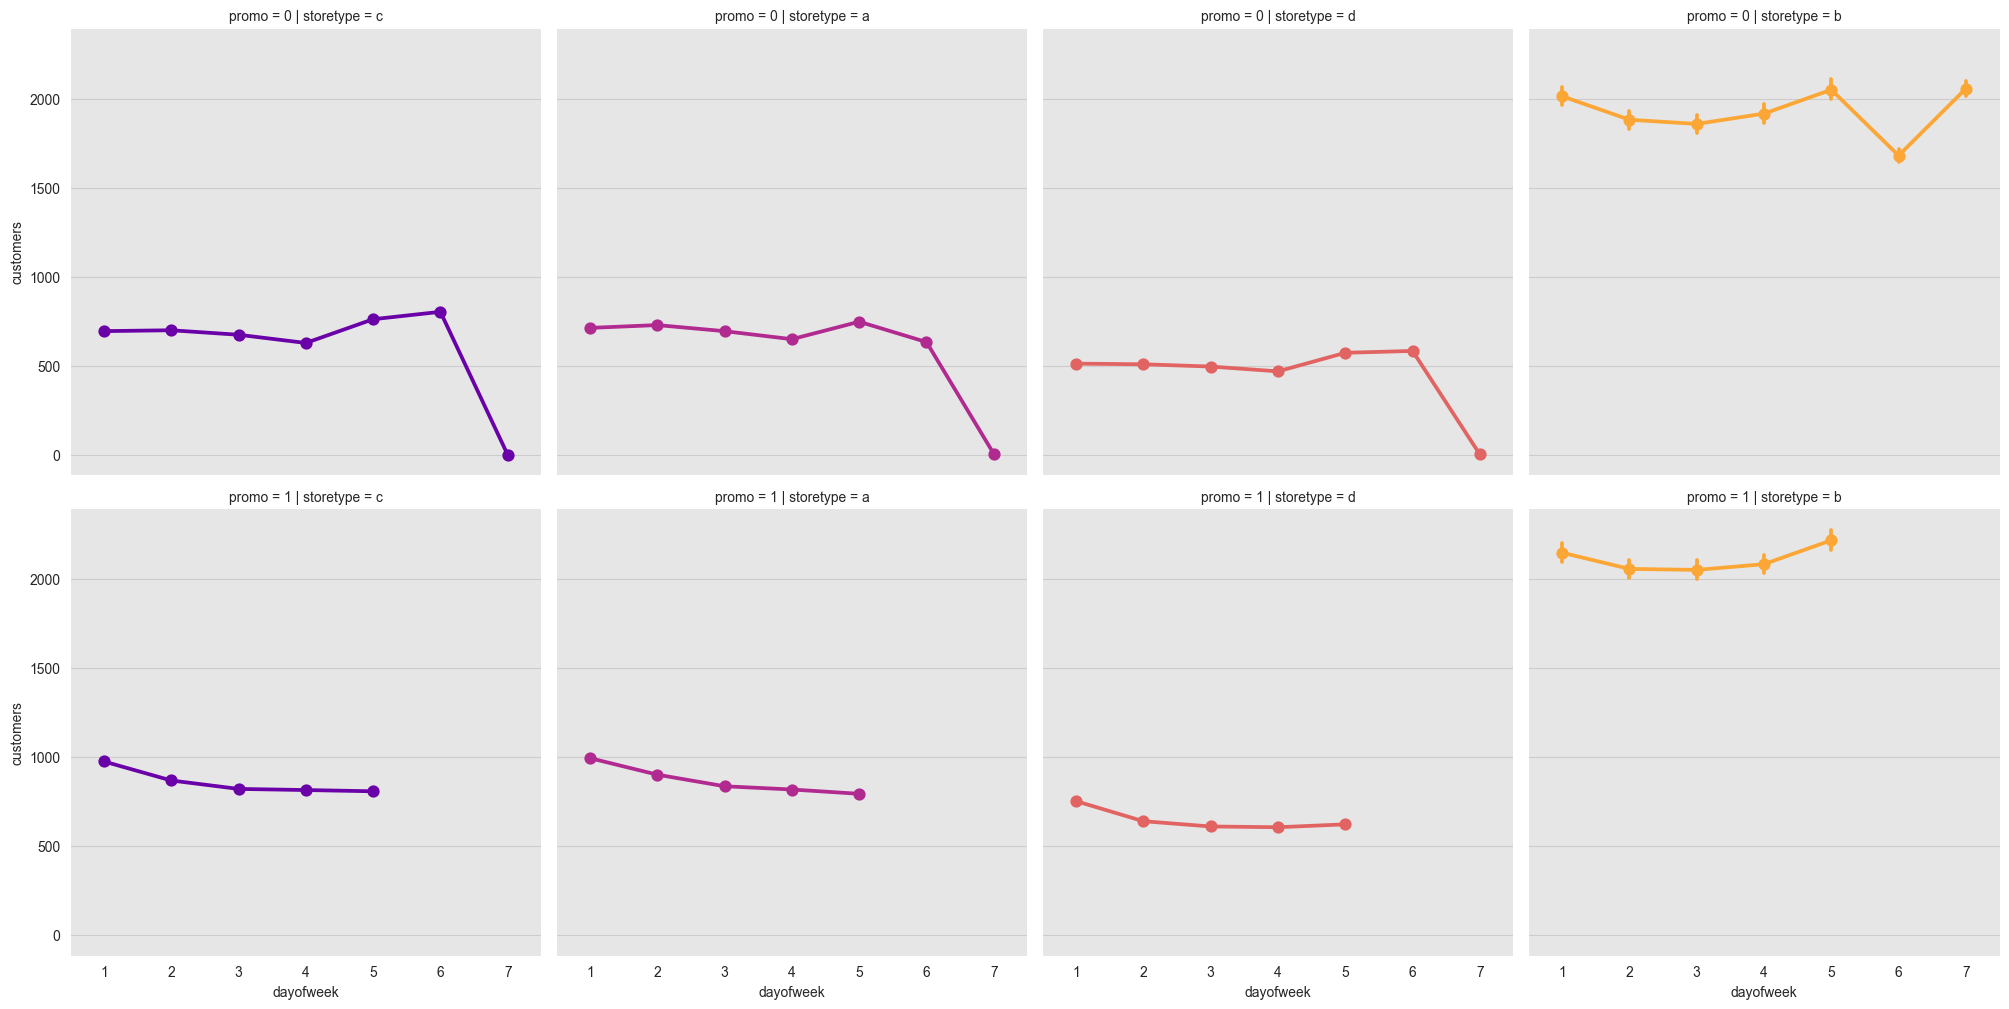

In [60]:
# weekday trends
sns.factorplot(data = df, x = 'dayofweek', y = "customers", 
               col = 'storetype',
               palette = 'plasma',
               hue = 'storetype',
               row = 'promo',
               ) 

## Finding

Promos are run only during the work-week, no promo on saturday/sunday.

Storetype b also open on sundays -> trainstation, fo sho
storetyp a lower number of customers on saturday, c and d increased

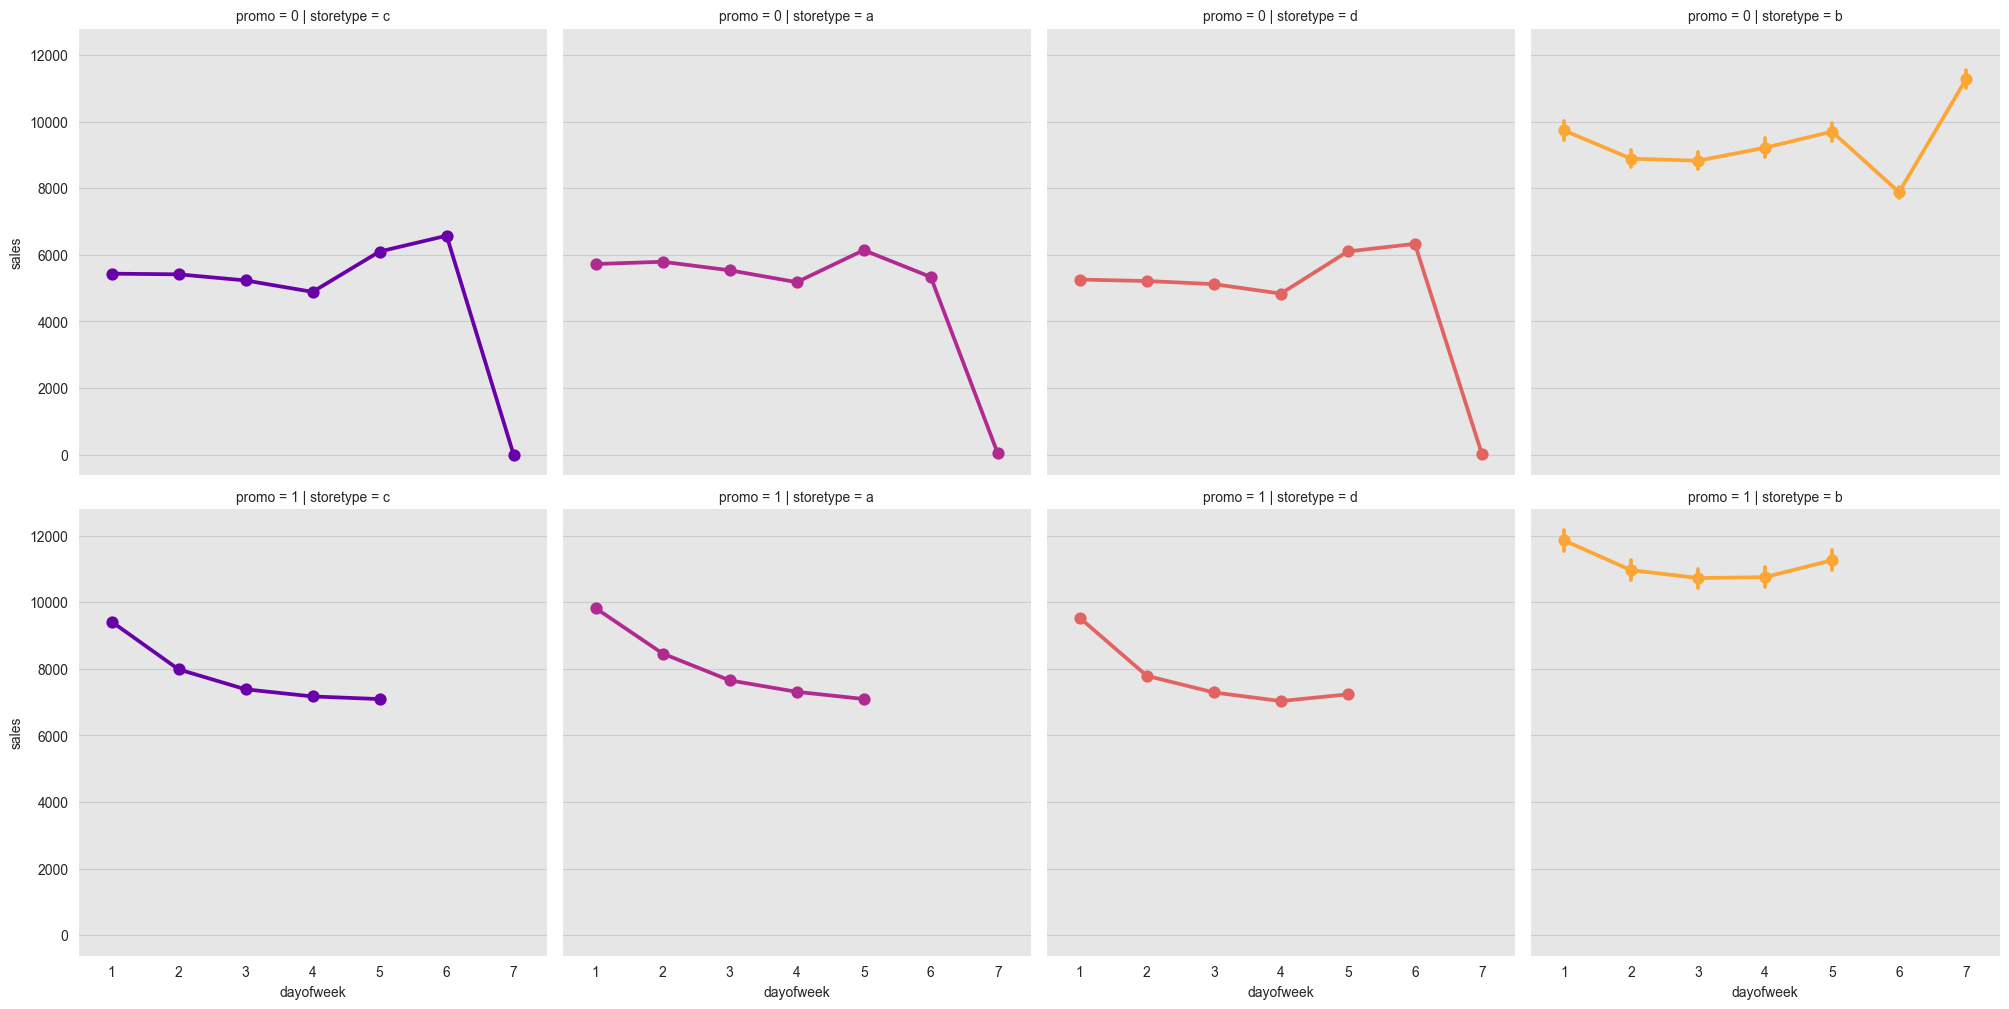

In [61]:
# weekday trends
sns.factorplot(data = df, x = 'dayofweek', y = "sales", 
               col = 'storetype',
               palette = 'plasma',
               hue = 'storetype',
               row = 'promo',
               ) 

Similar trends regarding sales numbers and customers.
Highest number of sales and customers on mondays, if a promo was run

## Conclusion : Question: Are the Promos effective?
- Promos are run only during the work-week, no promo on saturday/sunday
- Storetype B has the highest number of customers, with the largest variance
- Storetype B has the highest sales numbers, with the largest variance
- All storetypes show increased sales numbers towards christmas
- Stores which have run a promo, show higher sales. But storetypes a, c and d show a dip towards easter, if they have run a promo, which is not the case for       stores without a promo

In [62]:
## beachte: date, (assortment, storetype und stateholiday,assortment) müssen noch raus. die in der klammer sind schon durch kategorische Variablen ersetzt

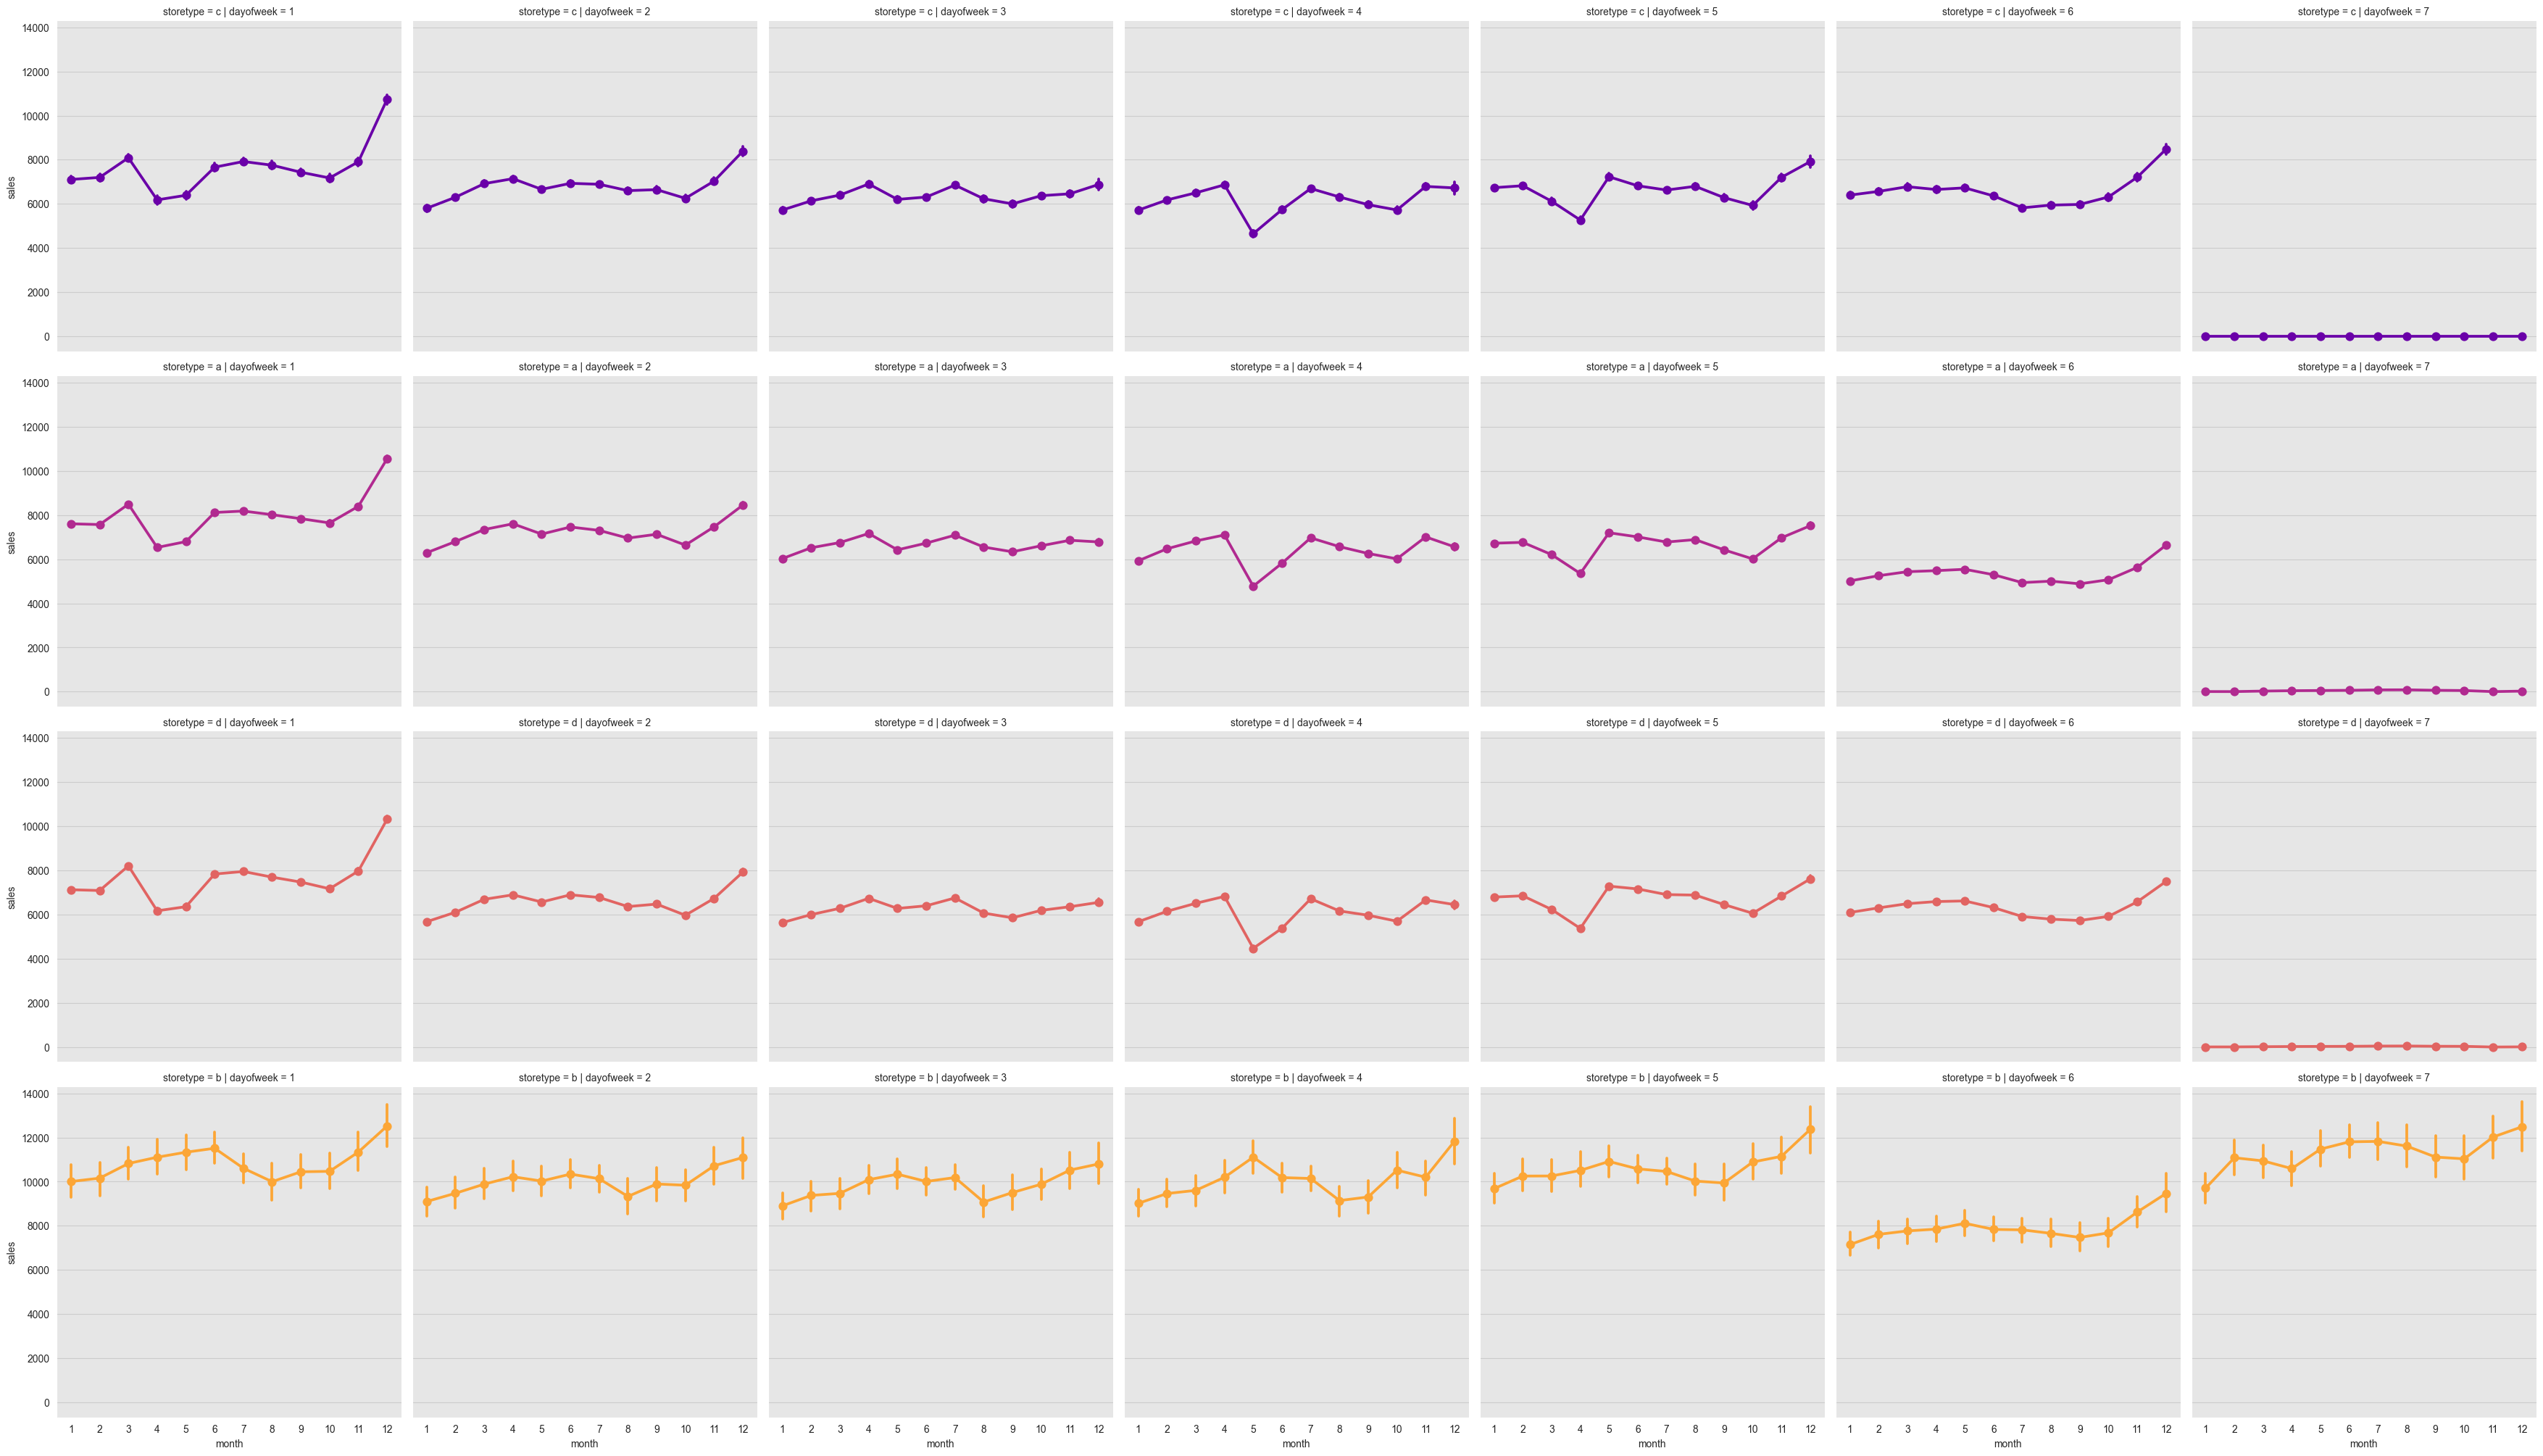

In [63]:
sns.factorplot(data = df, x = 'month', y = "sales", 
               col = 'dayofweek', 
               palette = 'plasma',
               hue = 'storetype',
               row = 'storetype',
               ) 

This shows the sales per storetyp across all months for each weekday.

In [64]:
# stores which are opened on Sundays
df[(df.open == 1) & (df.dayofweek == 7)]['store'].unique()

array([  85,  122,  209,  259,  262,  274,  299,  310,  335,  353,  423,
        433,  453,  494,  512,  524,  530,  562,  578,  676,  682,  732,
        733,  769,  863,  867,  931,  948, 1045, 1081, 1097, 1099,  877])

These are the stores, which are open on sundays.

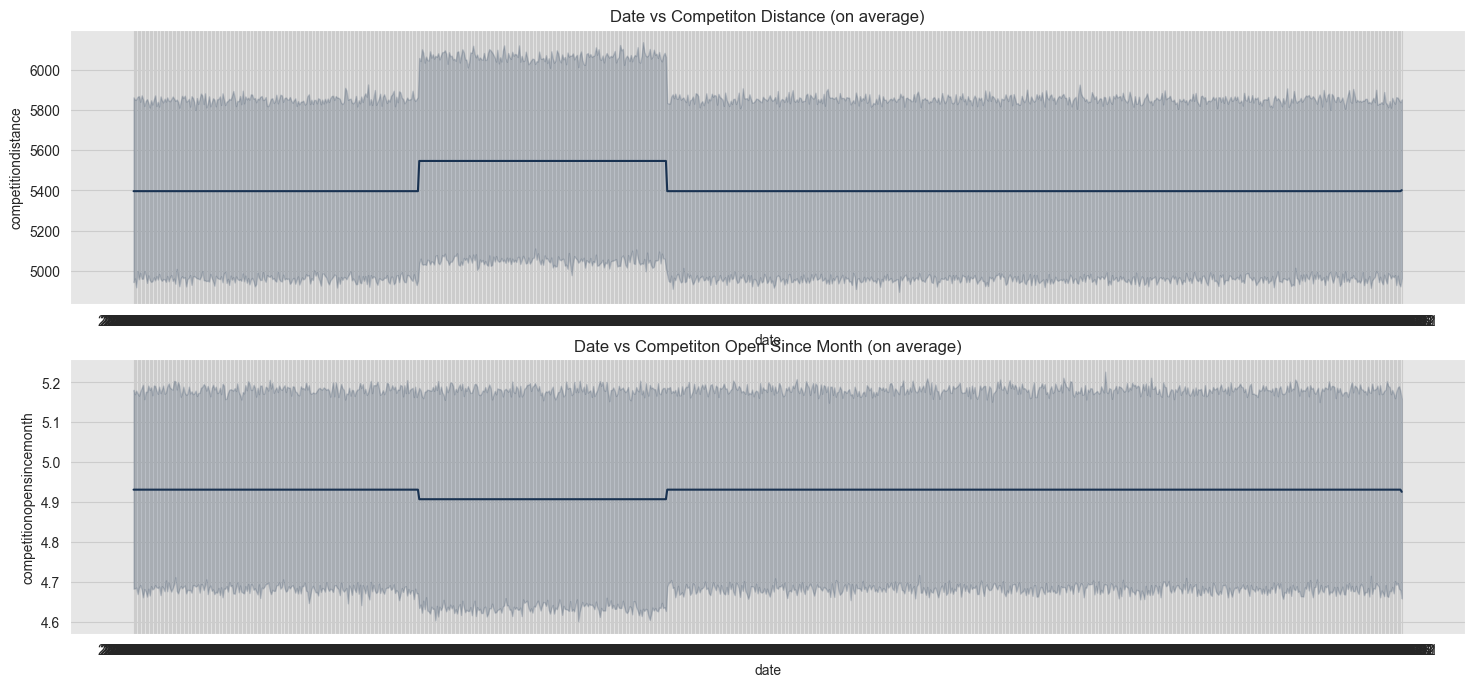

In [65]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18,8))
sns.lineplot(x = "date", y = df.groupby(df.index).mean()["competitiondistance"] , data=df, ax=axes[0])
sns.lineplot(x = "date", y = df.groupby(df.index).mean()["competitionopensincemonth"]  , data=df, ax=axes[1])

axes[0].set_title("Date vs Competiton Distance (on average)")
axes[1].set_title("Date vs Competiton Open Since Month (on average)")
plt.show()

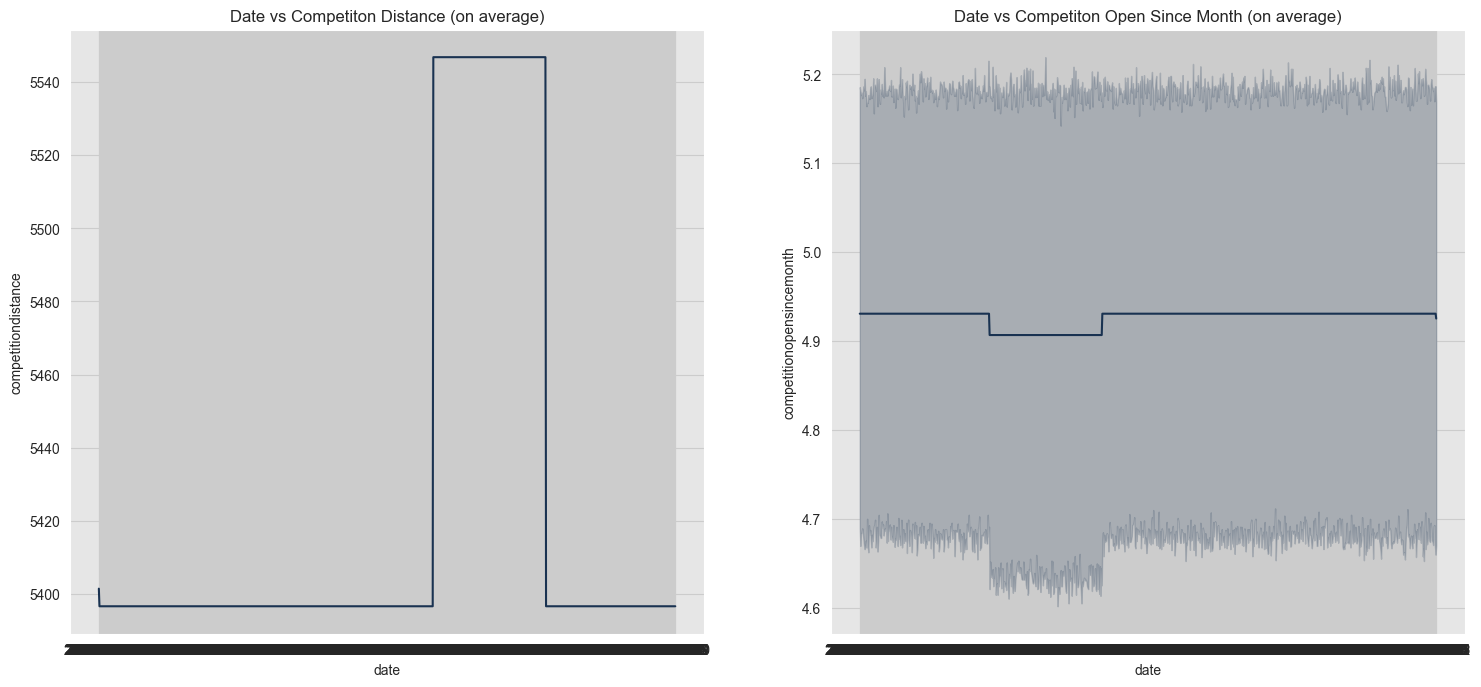

In [66]:
temp_df = df.copy()
temp_df.index = temp_df.date
temp_df = temp_df.groupby(temp_df.index).mean()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
sns.lineplot(x = "date", y = "competitiondistance" , data=temp_df, ax=axes[0])
sns.lineplot(x = "date", y = "competitionopensincemonth"  , data=df, ax=axes[1])

axes[0].set_title("Date vs Competiton Distance (on average)")
axes[1].set_title("Date vs Competiton Open Since Month (on average)")
plt.show()



In [67]:
df_store.describe().T

count         mean          std     min     25%  \
Store                      1115.0   558.000000   322.017080     1.0   279.5   
CompetitionDistance        1112.0  5404.901079  7663.174720    20.0   717.5   
CompetitionOpenSinceMonth   761.0     7.224704     3.212348     1.0     4.0   
CompetitionOpenSinceYear    761.0  2008.668857     6.195983  1900.0  2006.0   
Promo2                     1115.0     0.512108     0.500078     0.0     0.0   
Promo2SinceWeek             571.0    23.595447    14.141984     1.0    13.0   
Promo2SinceYear             571.0  2011.763573     1.674935  2009.0  2011.0   

                              50%     75%      max  
Store                       558.0   836.5   1115.0  
CompetitionDistance        2325.0  6882.5  75860.0  
CompetitionOpenSinceMonth     8.0    10.0     12.0  
CompetitionOpenSinceYear   2010.0  2013.0   2015.0  
Promo2                        1.0     1.0      1.0  
Promo2SinceWeek              22.0    37.0     50.0  
Promo2SinceYear            2012.0  2013.0   2015.0

<AxesSubplot:xlabel='Store', ylabel='CompetitionOpenSinceMonth'>

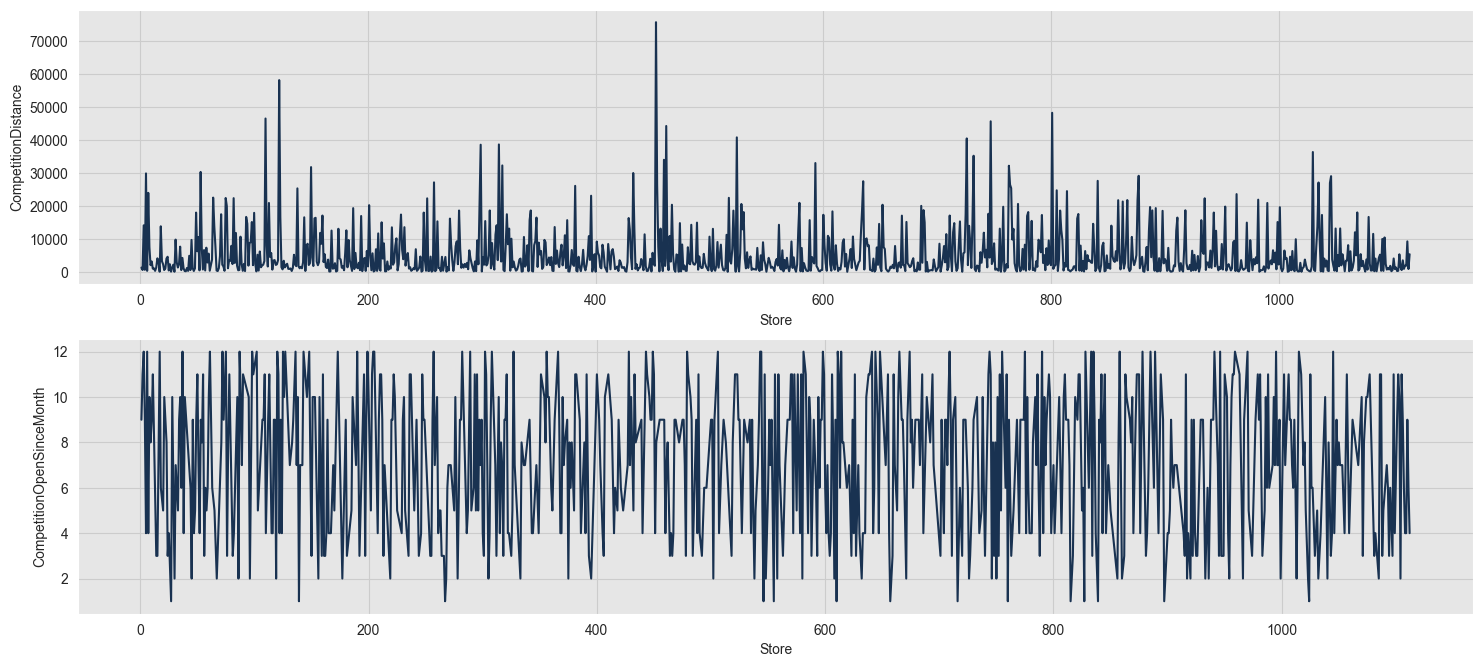

In [68]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18,8))
sns.lineplot(x = "Store", y = "CompetitionDistance" , data=df_store, ax=axes[0])
sns.lineplot(x = "Store", y = "CompetitionOpenSinceMonth"  , data=df_store, ax=axes[1])

<AxesSubplot:xlabel='CompetitionDistance', ylabel='Count'>

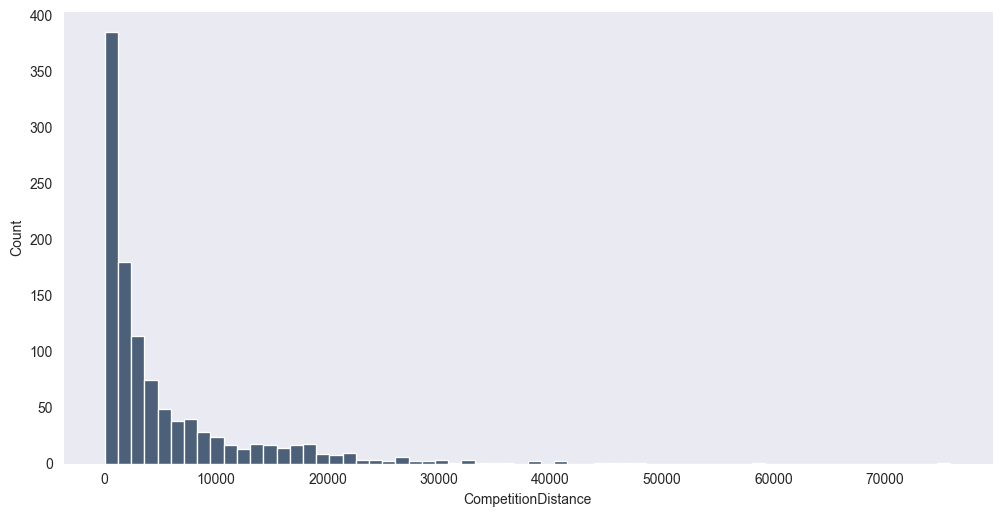

In [69]:
sns.set_style("dark")
sns.histplot(data=df_store, x="CompetitionDistance")


Text(0.5, 1.0, 'Number of Different Assortments per Store Type')

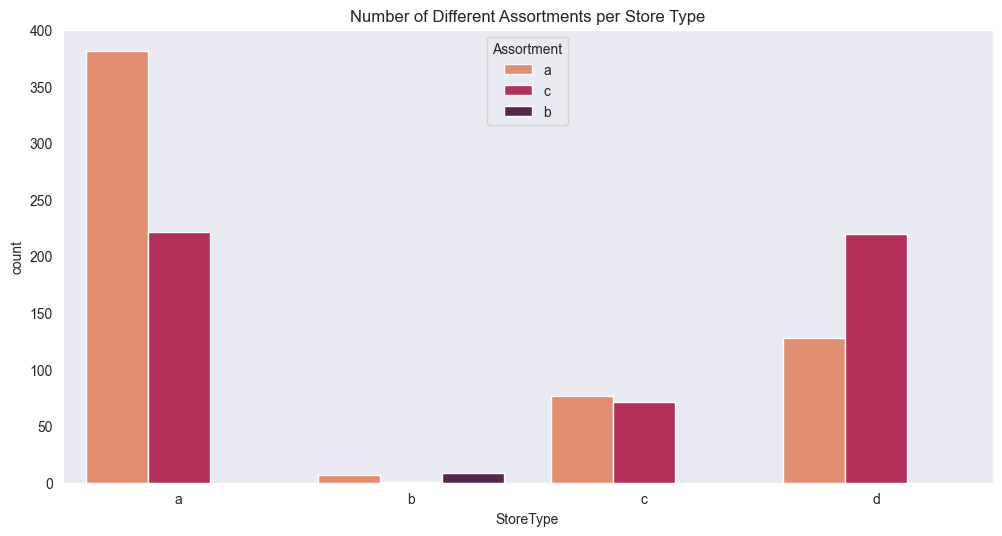

In [70]:
sns.countplot(x="StoreType",hue="Assortment",order=["a","b","c","d"], 
                                     data=df_store,palette="rocket_r").set_title("Number of Different Assortments per Store Type")

## Aggregated Plots

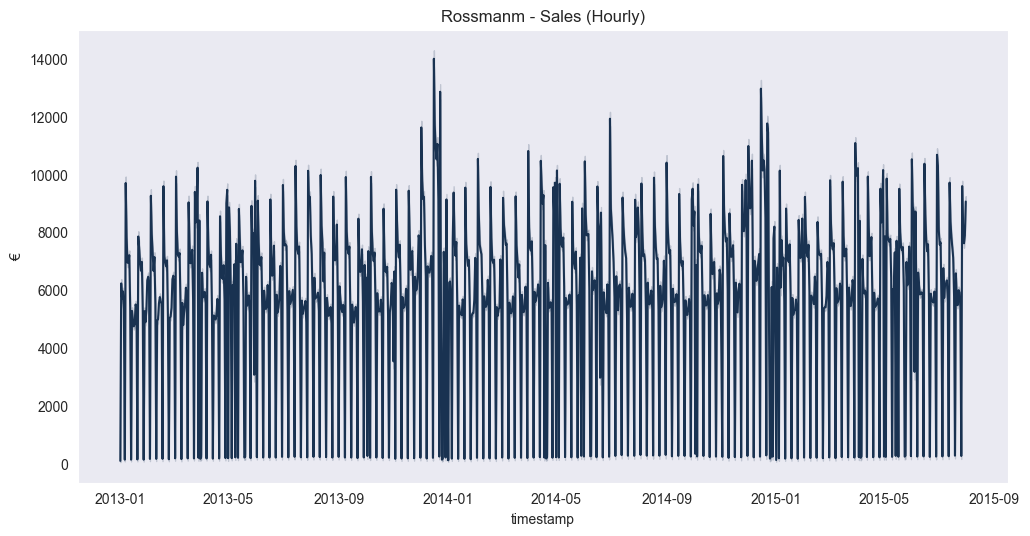

In [71]:
fig, ax = plt.subplots()
sns.lineplot(x='timestamp', y='sales', data=df, ax=ax)
ax.set(title='Rossmanm - Sales (Hourly)', ylabel="€");

In [72]:
# Aggregate Sales by day
daily_data_df = df \
    .groupby([ "date",'year', 'month', 'day', 'dayofyear'], as_index=False)\
    .agg({'sales': np.mean}) \
    .set_index('date')

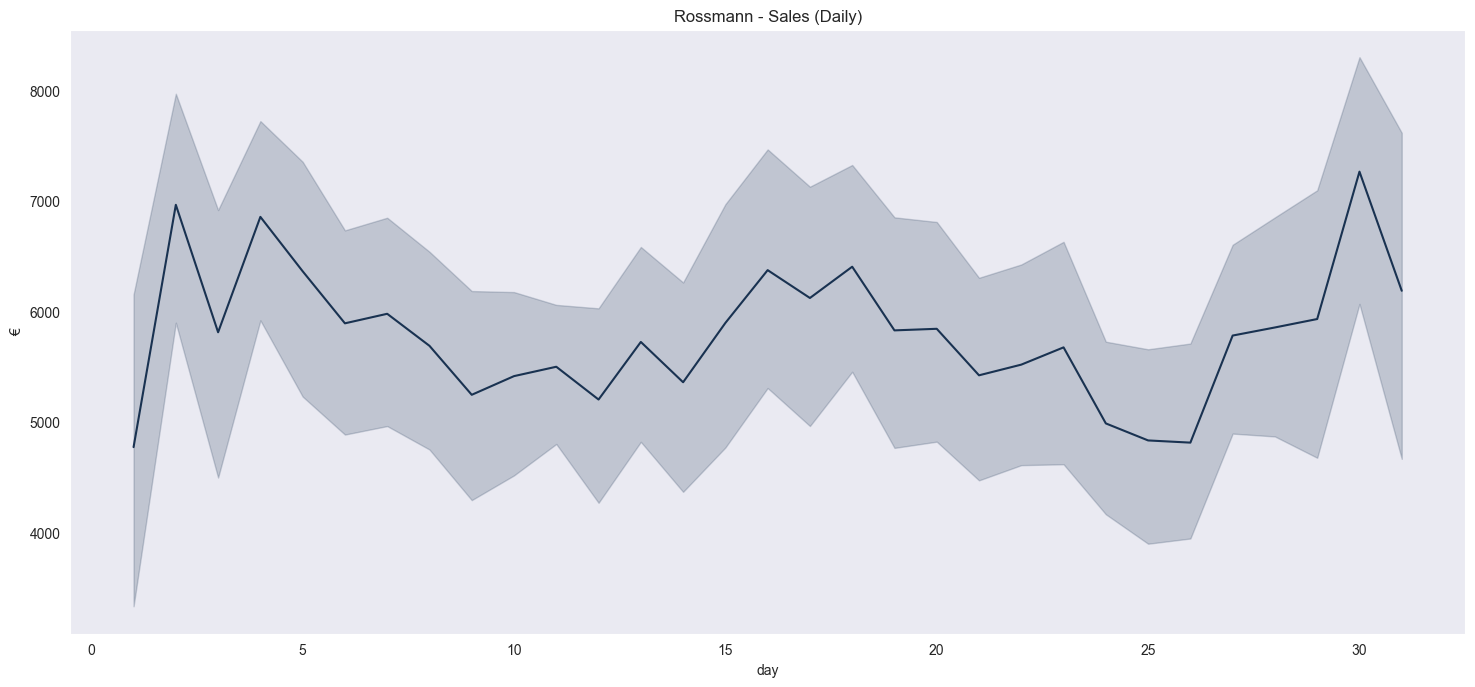

In [73]:
# Plot Sales on daily basis 
fig, ax = plt.subplots(figsize=(18,8))
sns.lineplot(x='day', y='sales', data=daily_data_df.reset_index(), ax=ax)
ax.set(title='Rossmann - Sales (Daily)', ylabel="€");

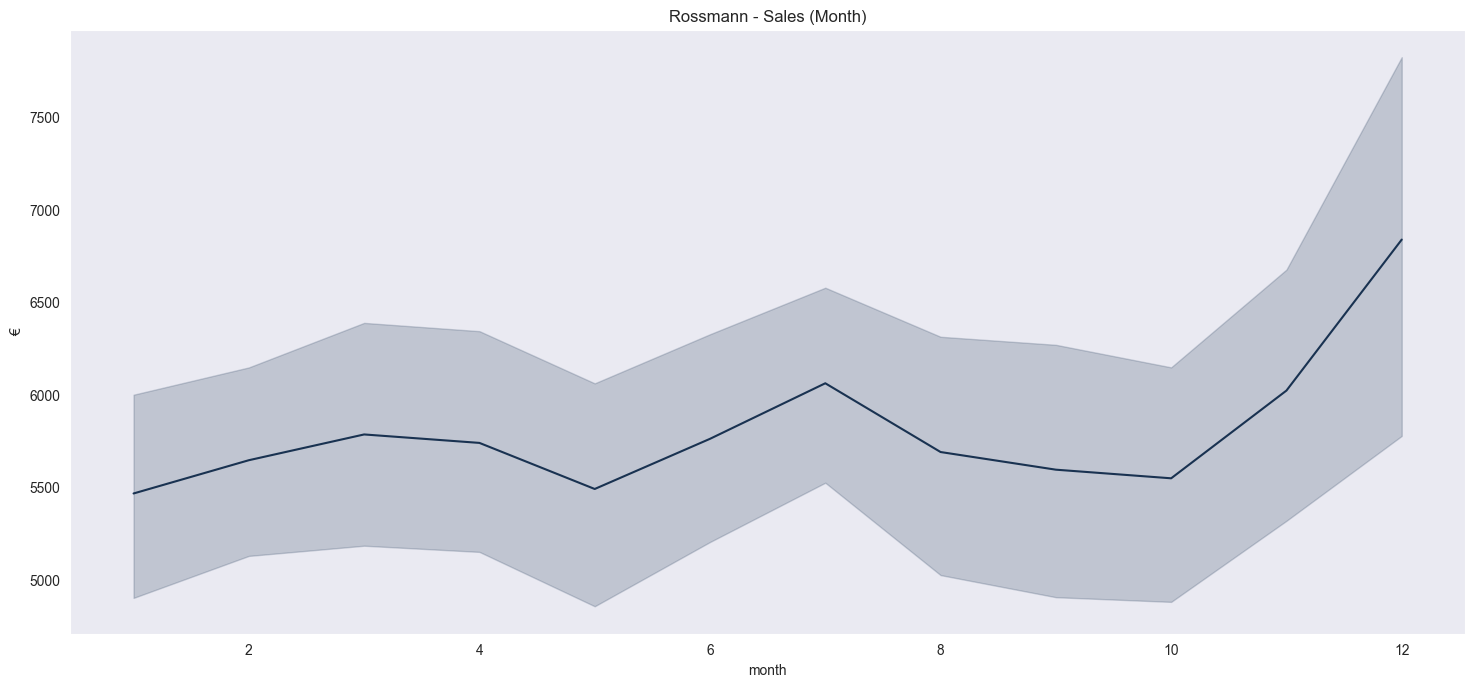

In [74]:
# Plot Sales on month basis 
fig, ax = plt.subplots(figsize=(18,8))
sns.lineplot(x='month', y='sales', data=daily_data_df.reset_index(), ax=ax)
ax.set(title='Rossmann - Sales (Month)', ylabel="€");

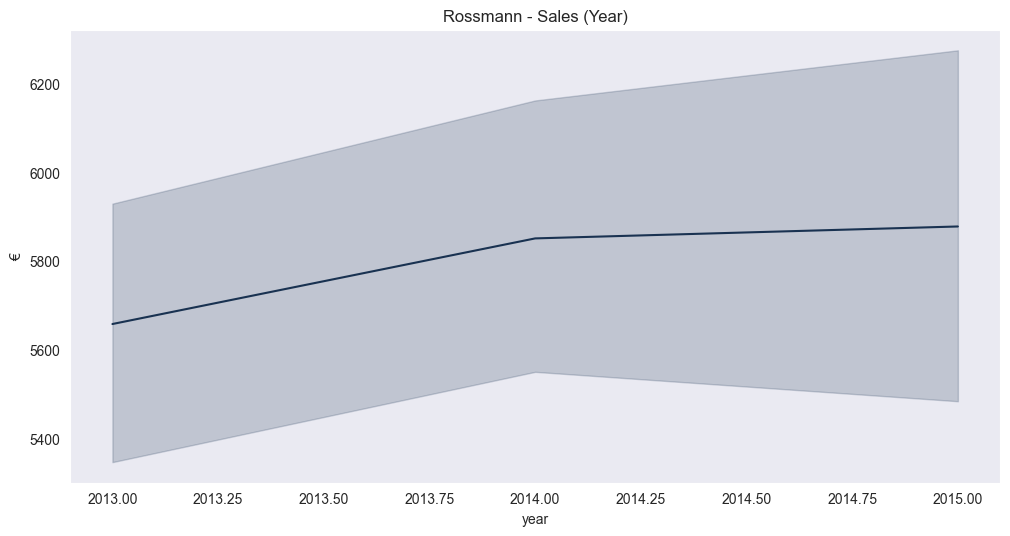

In [75]:
# Plot Sales on year basis 
fig, ax = plt.subplots()
sns.lineplot(x='year', y='sales', data=daily_data_df.reset_index(), ax=ax)
ax.set(title='Rossmann - Sales (Year)', ylabel="€");

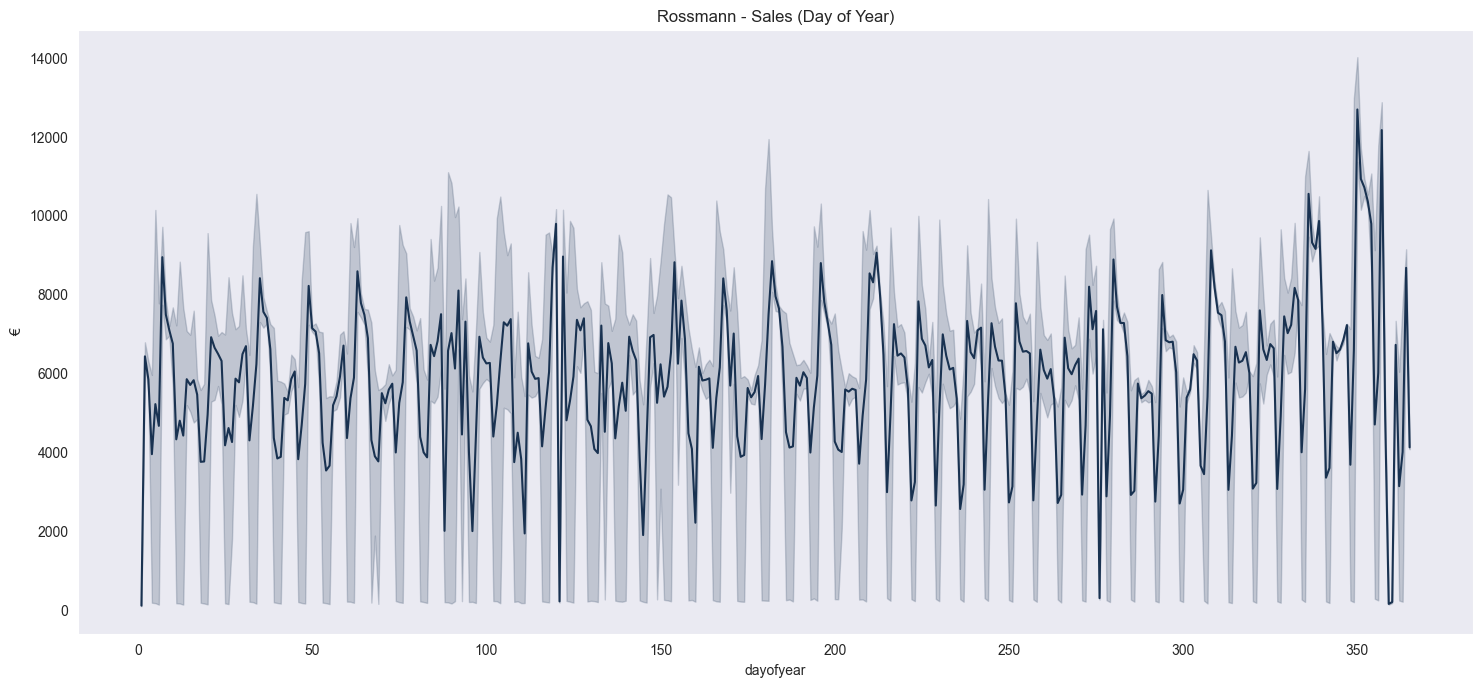

In [76]:
# Plot Sales on month basis 
fig, ax = plt.subplots(figsize=(18,8))
sns.lineplot(x='dayofyear', y='sales', data=daily_data_df.reset_index(), ax=ax)
ax.set(title='Rossmann - Sales (Day of Year)', ylabel="€");

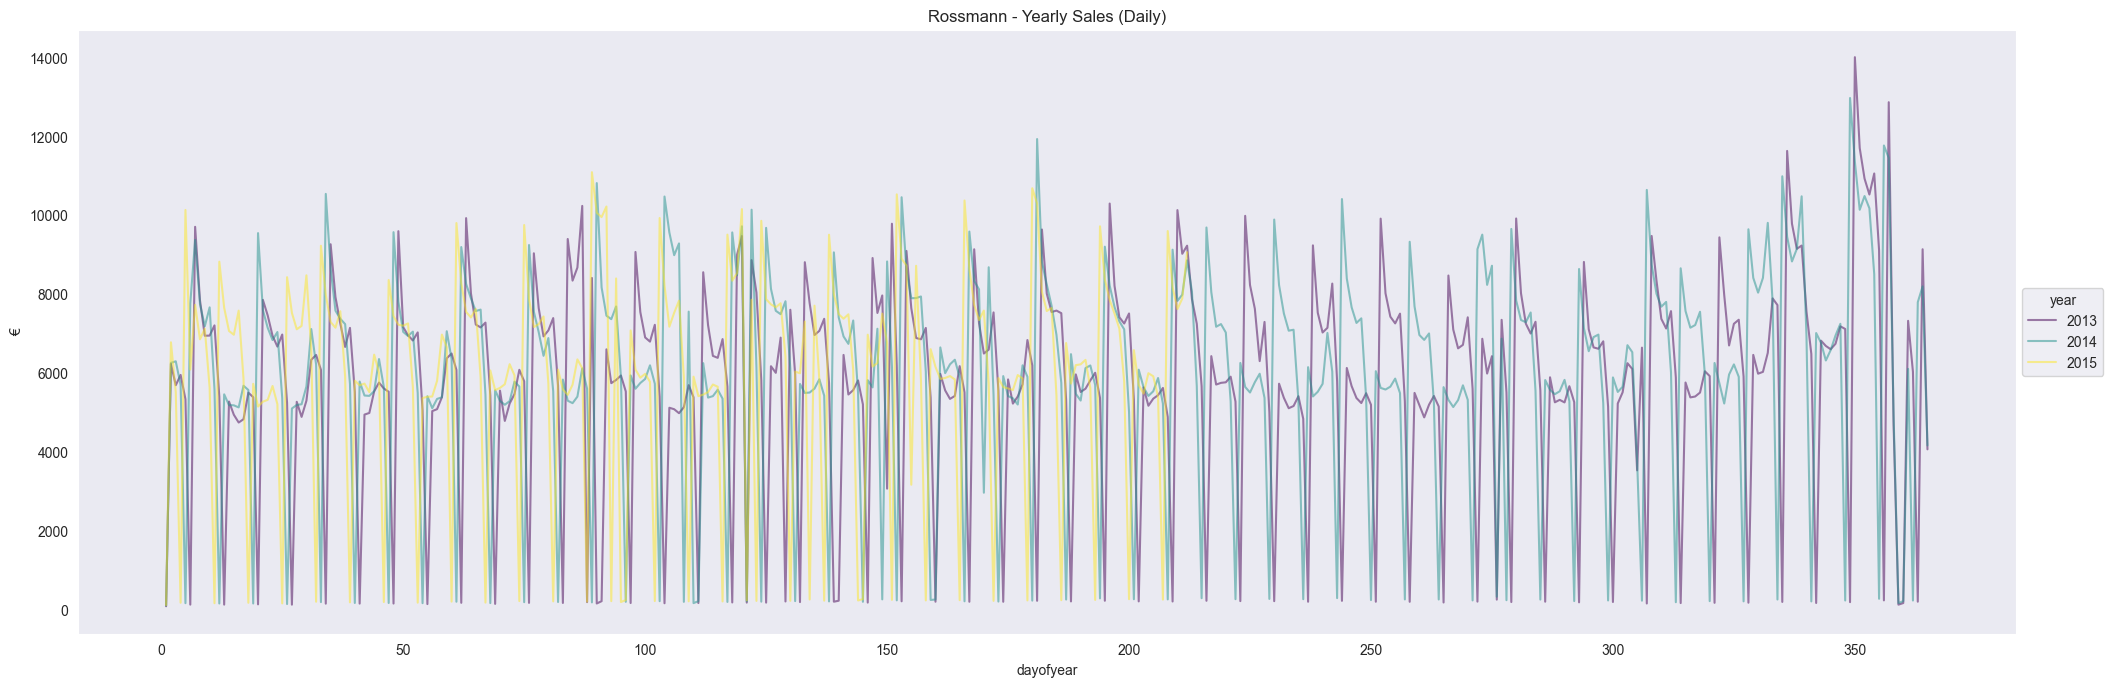

In [77]:
# Plot yearly seasonality
fig, ax = plt.subplots(figsize=(25,8)) 

pd.pivot_table(data=daily_data_df[['year', 'dayofyear', 'sales']], index='dayofyear', columns='year') \
    ['sales'] \
    .plot(cmap='viridis', alpha=0.5, ax=ax)

ax.legend(title='year', loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Rossmann - Yearly Sales (Daily)', ylabel="€");

# Smoothing

Usuall the first question of data analysis is "Can we extract general, global pattern here?" In time series with cyclic seasonal variation, 
this means that we want to smooth out this seasonality and let the global trend manifest itself. Most classical, first go-to way for this 
smoothing is to use Moving Average.

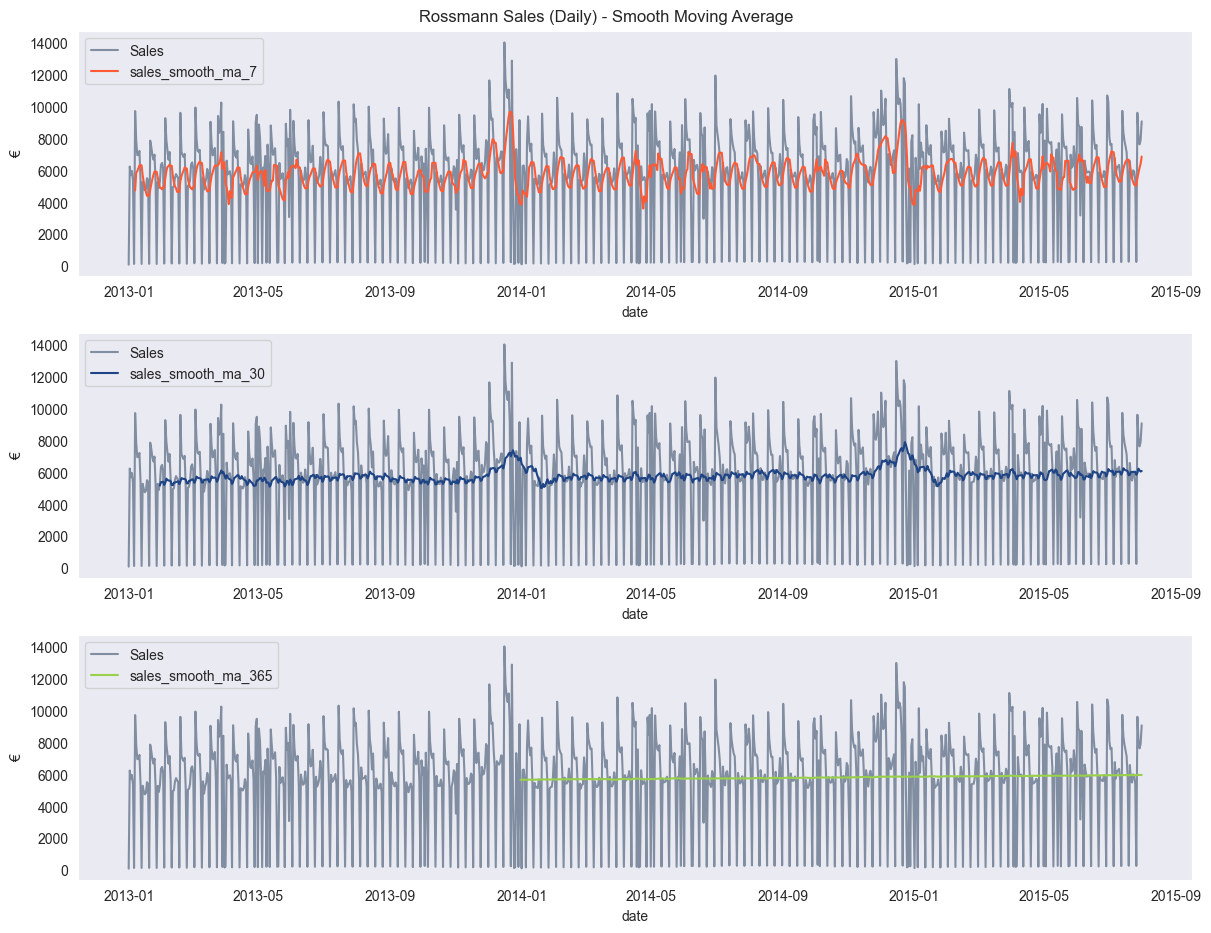

In [78]:
# Plot moving average of different length (week, month, year)
ma = [7, 30, 365]

smooth_daily_data_df = daily_data_df \
    .reset_index() \
    .assign(date = lambda x: x['date'].transform(pd.to_datetime))

# Smooth and plot
fig, ax = plt.subplots(3, 1, figsize=(12, 9), constrained_layout=True)

for i, m in enumerate(ma):

    smooth_daily_data_df[f'sales_smooth_ma_{m}'] = smooth_daily_data_df['sales'].rolling(window=m).mean()

    sns.lineplot(x='date', y='sales', label='Sales', data=smooth_daily_data_df, alpha=0.5, ax=ax[i])
    sns.lineplot(x='date', y=f'sales_smooth_ma_{m}', label=f'sales_smooth_ma_{m}', data=smooth_daily_data_df, color=sns_c[i + 1], ax=ax[i])
    ax[i].legend(loc='upper left')
    ax[i].set(title='', ylabel="€");

plt.suptitle('Rossmann Sales (Daily) - Smooth Moving Average', y=1.02);

Using the moving average of 365 units relfects the yearly structure of the data (lowest panel in the plot above).

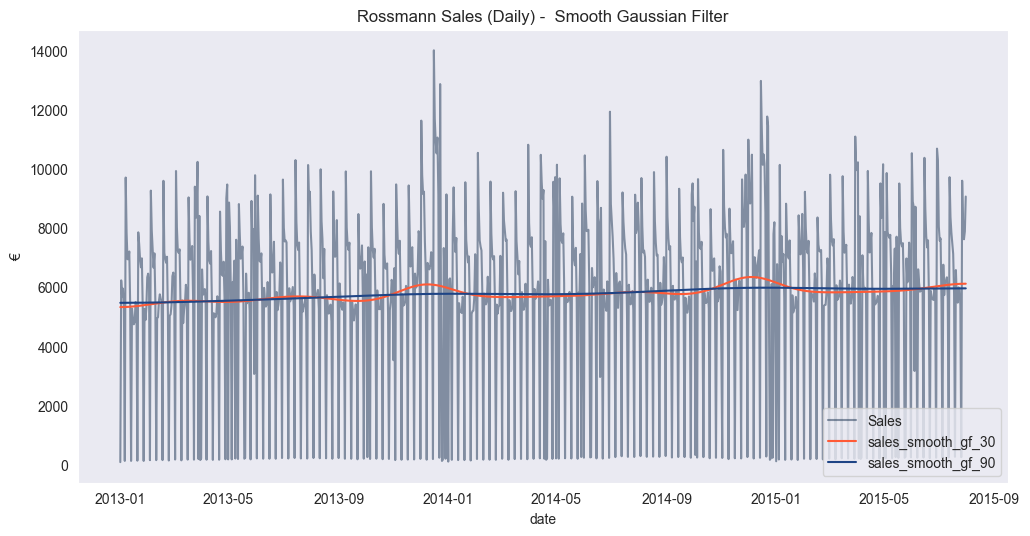

In [79]:
# Smooth data with gaussion filter
smooth_daily_data_df = smooth_daily_data_df \
    .assign(sales_smooth_gf_30 = lambda x: gaussian_filter(input=x['sales'], sigma=30)) \
    .assign(sales_smooth_gf_90 = lambda x: gaussian_filter(input=x['sales'], sigma=90))

# Plot data
fig, ax = plt.subplots()
sns.lineplot(x='date', y='sales', label='Sales', data=smooth_daily_data_df, alpha=0.5, ax=ax)
sns.lineplot(x='date', y='sales_smooth_gf_30', label='sales_smooth_gf_30', data=smooth_daily_data_df, color=sns_c[1], ax=ax)
sns.lineplot(x='date', y='sales_smooth_gf_90', label='sales_smooth_gf_90', data=smooth_daily_data_df, color=sns_c[2], ax=ax)
ax.legend(loc='lower right')
ax.set(title='Rossmann Sales (Daily) -  Smooth Gaussian Filter', ylabel="€");

Let us use this smoothing to plot again the seasonality yearly Sales:

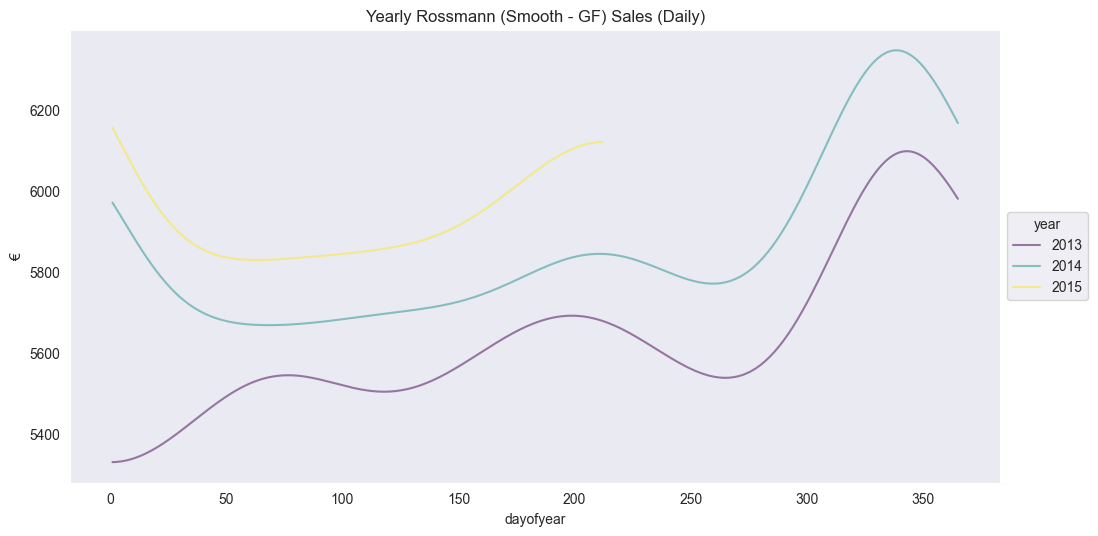

In [80]:
# Plot seasonal yearly sales 
fig, ax = plt.subplots() 

pd.pivot_table(data=smooth_daily_data_df[['year', 'dayofyear', 'sales_smooth_gf_30']], index='dayofyear', columns='year') \
    ['sales_smooth_gf_30'] \
    .plot(cmap='viridis', alpha=0.5, ax=ax)

ax.legend(title='year', loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Yearly Rossmann (Smooth - GF) Sales (Daily)', ylabel="€");

## Time Series Decomposition


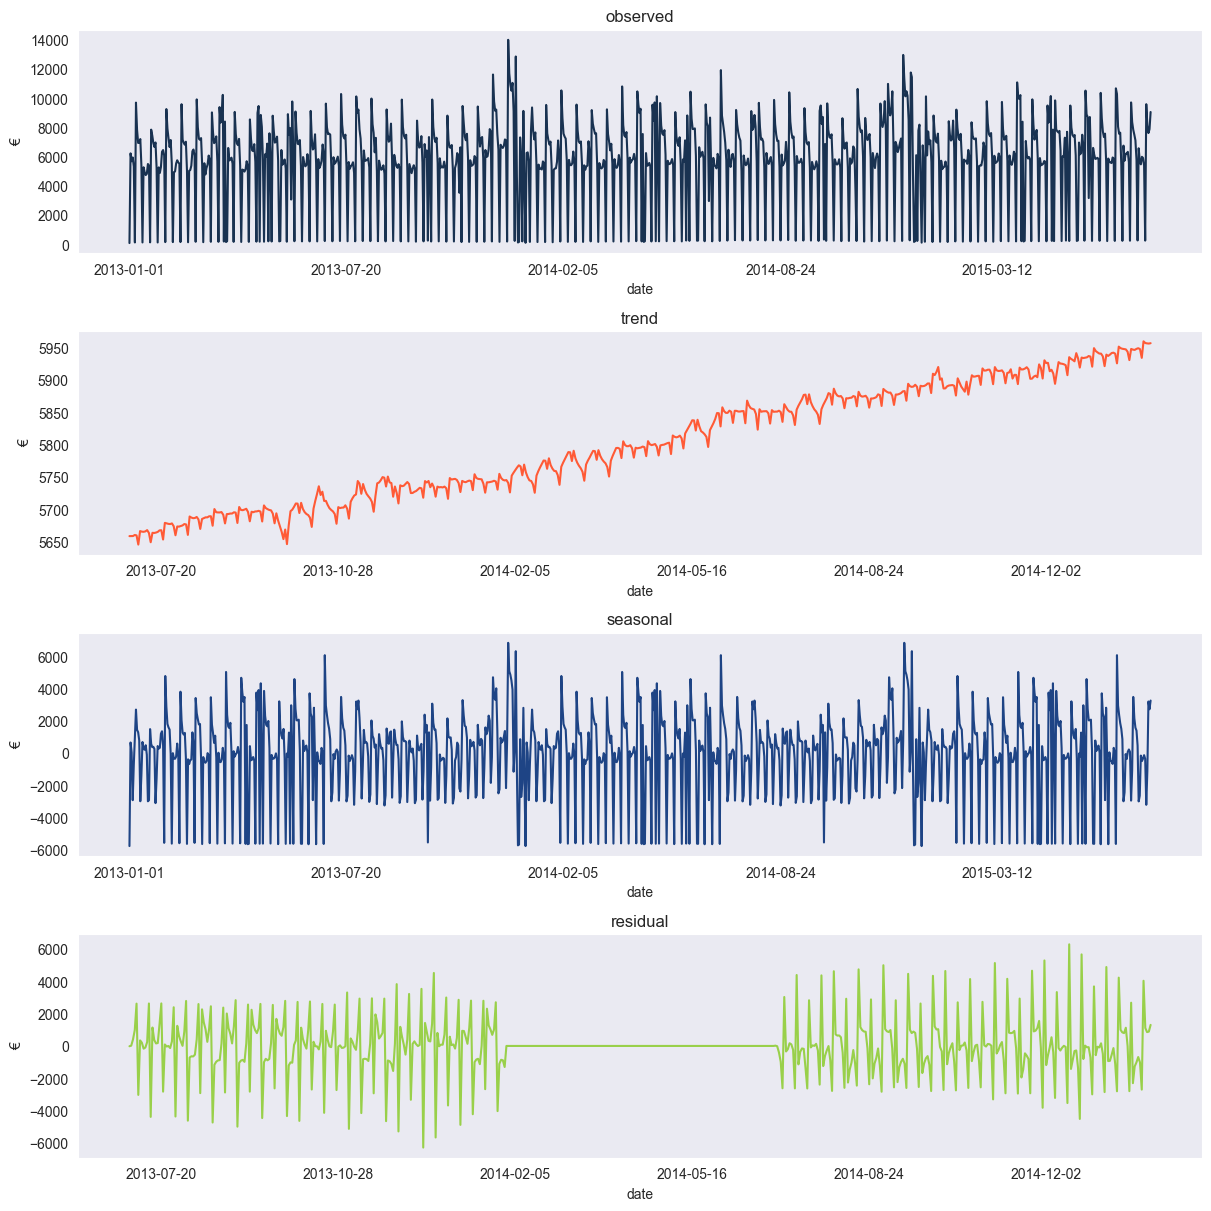

In [81]:
# We use the parameter `period` = 365 to extract the yearly seasonality. 
seas_decomp_yearly = seasonal_decompose(
    x=daily_data_df['sales'], 
    model='additive', 
    period=365
)

# Plot data
fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)

seas_decomp_yearly.observed.plot(c=sns_c[0], ax=ax[0])
ax[0].set(title='observed', ylabel="€")
seas_decomp_yearly.trend.plot(c=sns_c[1], ax=ax[1])
ax[1].set(title='trend', ylabel="€")
seas_decomp_yearly.seasonal.plot(c=sns_c[2], ax=ax[2])
ax[2].set(title='seasonal', ylabel="€")
seas_decomp_yearly.resid.plot(c=sns_c[3], ax=ax[3])
ax[3].set(title='residual', ylabel="€");

We can now decompose the seasonal component from above. 

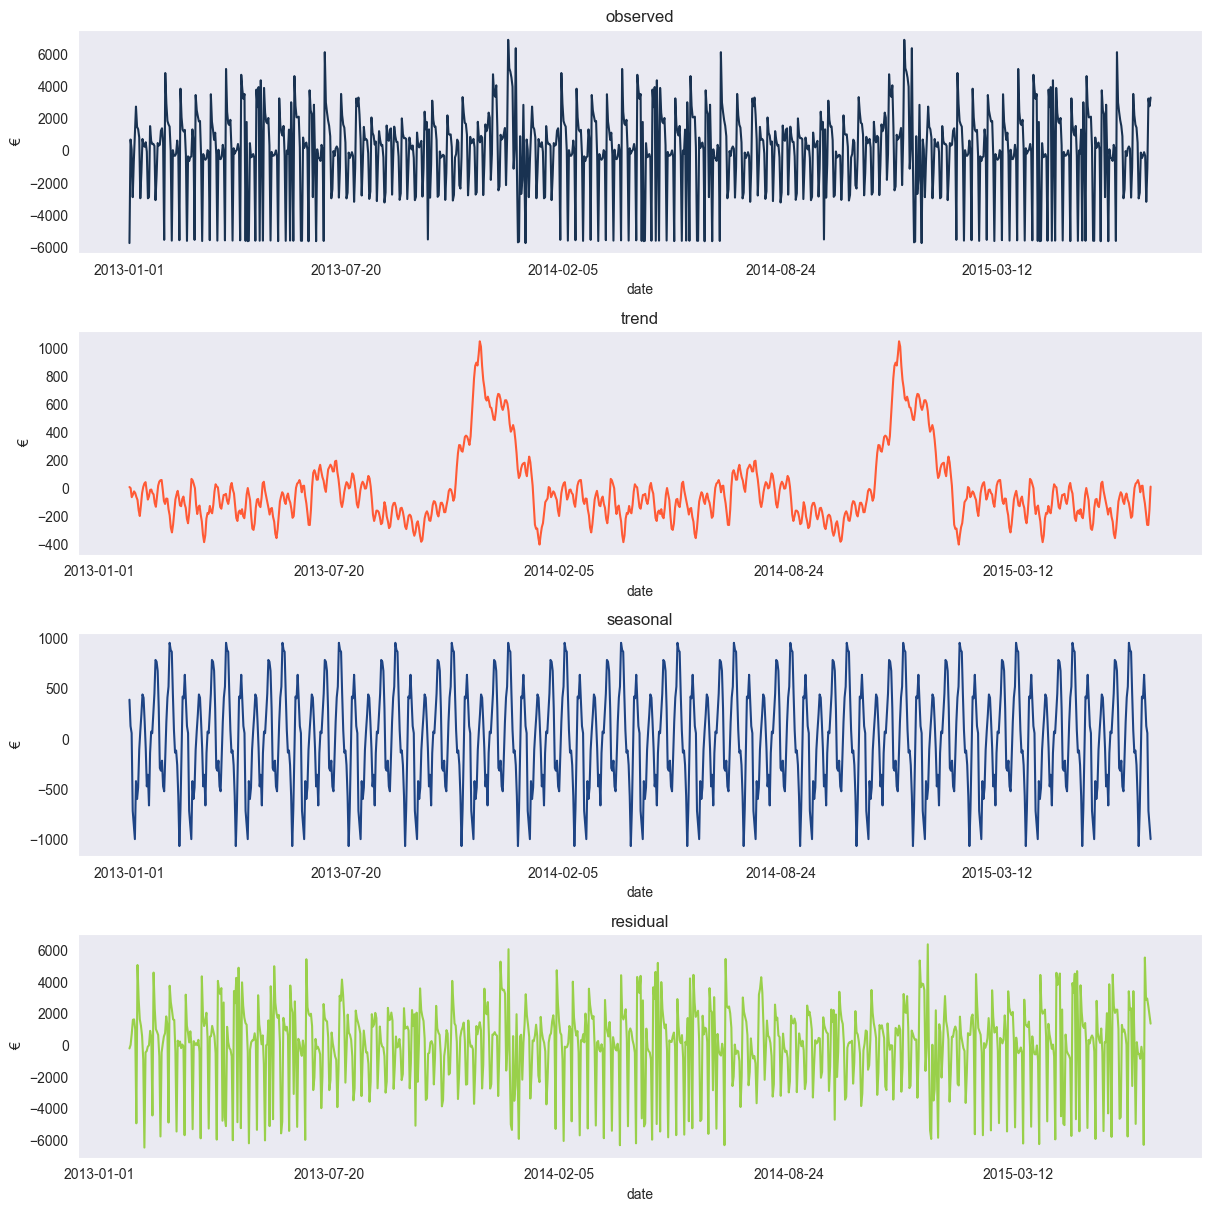

In [82]:
seas_decomp_monthly = seasonal_decompose(
    x=seas_decomp_yearly.seasonal, 
    model='additive', 
    period=52
)

# Plot data
fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)

seas_decomp_monthly.observed.plot(c=sns_c[0], ax=ax[0])
ax[0].set(title='observed', ylabel="€")
seas_decomp_monthly.trend.plot(c=sns_c[1], ax=ax[1])
ax[1].set(title='trend', ylabel="€")
seas_decomp_monthly.seasonal.plot(c=sns_c[2], ax=ax[2])
ax[2].set(title='seasonal', ylabel="€")
seas_decomp_monthly.resid.plot(c=sns_c[3], ax=ax[3])
ax[3].set(title='residual', ylabel="€");

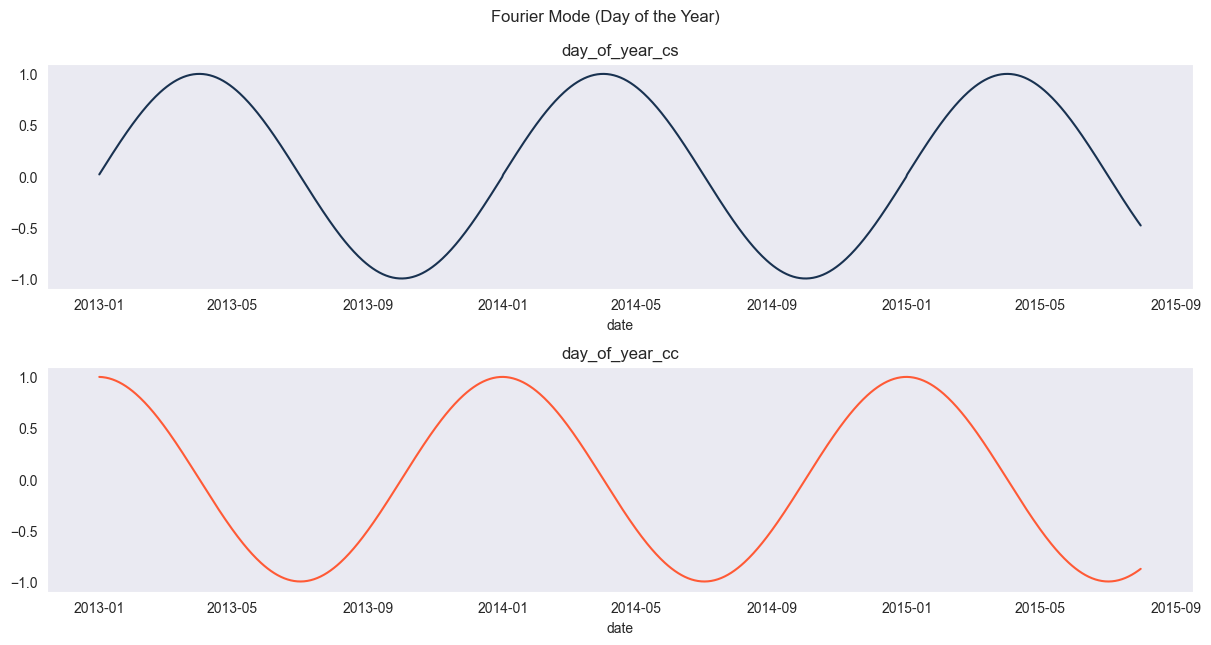

In [83]:
# Create linear trend and cyclical variables to model the day of the year. 
smooth_daily_data_df = smooth_daily_data_df.assign(
    index = lambda x: np.linspace(start=0, stop=x.shape[0]-1, num=x.shape[0]),
    day_of_year_cs = lambda x: np.sin(2*np.pi*x['dayofyear']/365.5),
    day_of_year_cc = lambda x: np.cos(2*np.pi*x['dayofyear']/365.5)
)

# Plot data
fig, ax = plt.subplots(2, 1, constrained_layout=True)
sns.lineplot(x='date', y='day_of_year_cs', data=smooth_daily_data_df, color=sns_c[0], ax=ax[0])
ax[0].set(title='day_of_year_cs', ylabel='')
sns.lineplot(x='date', y='day_of_year_cc', data=smooth_daily_data_df, color=sns_c[1], ax=ax[1])
ax[1].set(title='day_of_year_cc', ylabel='')
plt.suptitle('Fourier Mode (Day of the Year)', y=1.05);

Next, we use a linear model to fit each component:

In [84]:
# Define model
decomp_model = smf.ols(formula = 'sales ~ index + day_of_year_cs + day_of_year_cc', data=smooth_daily_data_df)

# Train model
decomp_red = decomp_model.fit()
print(decomp_red.summary()) 

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.365
Date:                Wed, 21 Jul 2021   Prob (F-statistic):              0.252
Time:                        15:00:28   Log-Likelihood:                -8840.4
No. Observations:                 942   AIC:                         1.769e+04
Df Residuals:                     938   BIC:                         1.771e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       5503.6398    189.532     29.

Finally, let us extract each component.

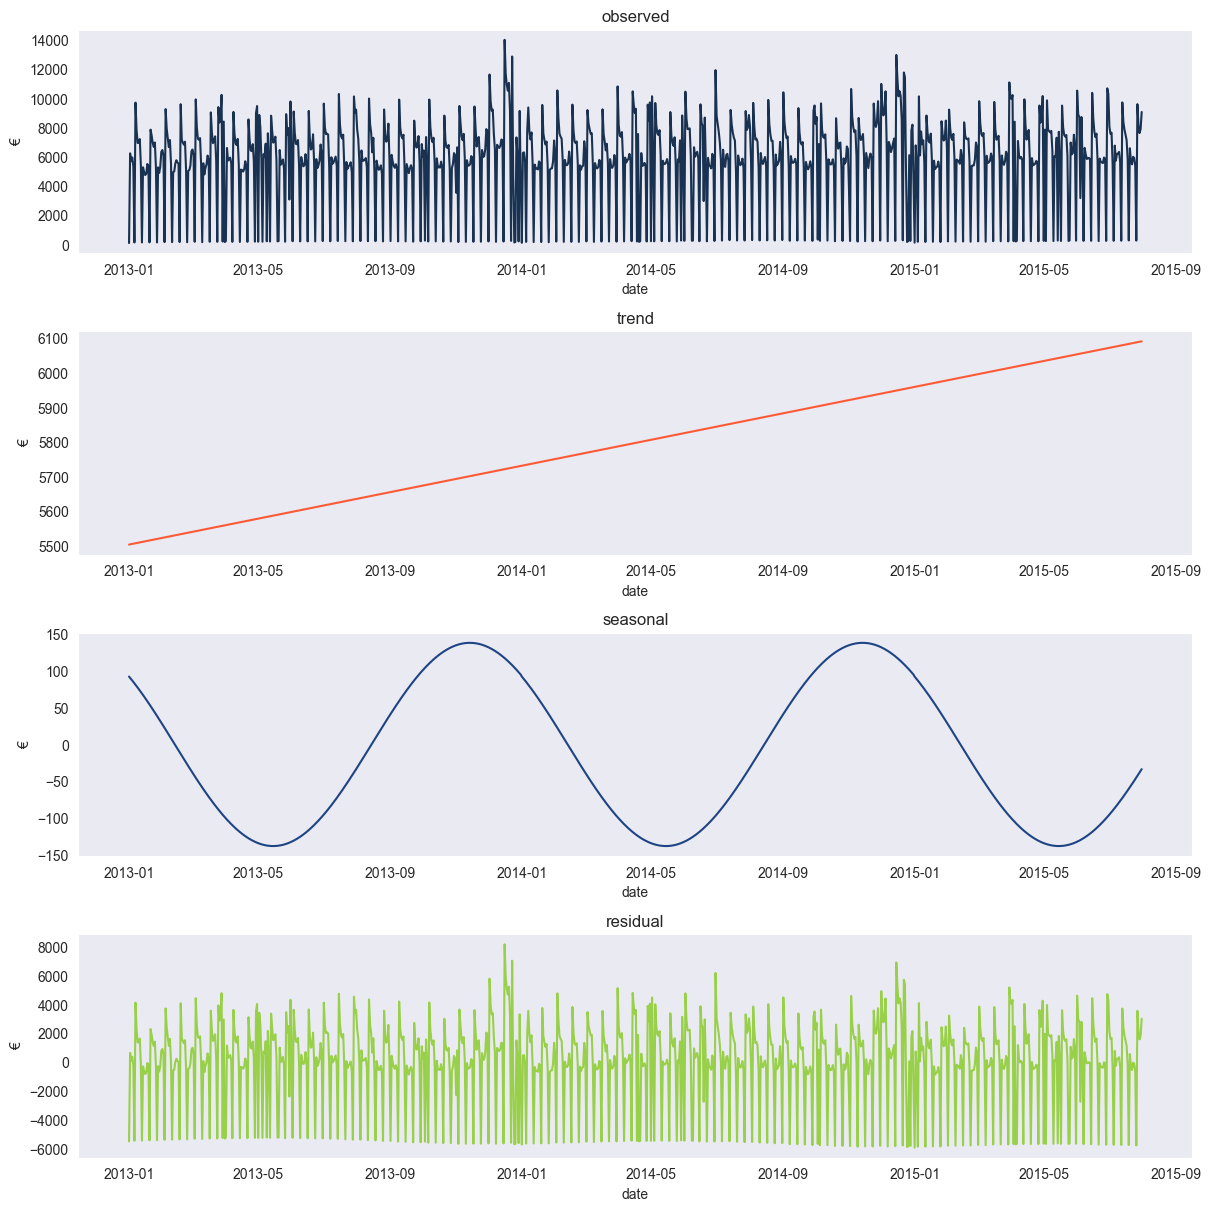

In [85]:
smooth_daily_data_df = smooth_daily_data_df.assign(
    decomp_trend = decomp_red.predict(smooth_daily_data_df.assign(day_of_year_cs = 0.0, day_of_year_cc = 0.0)),
    decomp_seas = decomp_red.predict(smooth_daily_data_df.assign(index = 0.0)) - decomp_red.params['Intercept'],
    decomp_error = lambda x: x['sales'] - x['decomp_trend'] - x['decomp_seas']
)

fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)

sns.lineplot(x='date', y='sales', data=smooth_daily_data_df, color=sns_c[0], ax=ax[0])
ax[0].set(title='observed', ylabel="€")

sns.lineplot(x='date', y='decomp_trend', data=smooth_daily_data_df, color=sns_c[1], ax=ax[1])
ax[1].set(title='trend', ylabel="€")

sns.lineplot(x='date', y='decomp_seas', data=smooth_daily_data_df, color=sns_c[2], ax=ax[2])
ax[2].set(title='seasonal', ylabel="€")

sns.lineplot(x='date', y='decomp_error', data=smooth_daily_data_df, color=sns_c[3], ax=ax[3])
ax[3].set(title='residual', ylabel="€");

#plt.savefig(f'../images/rossmann_daily_decomp_fourier.png', dpi=200, bbox_inches='tight');

## notebook 2

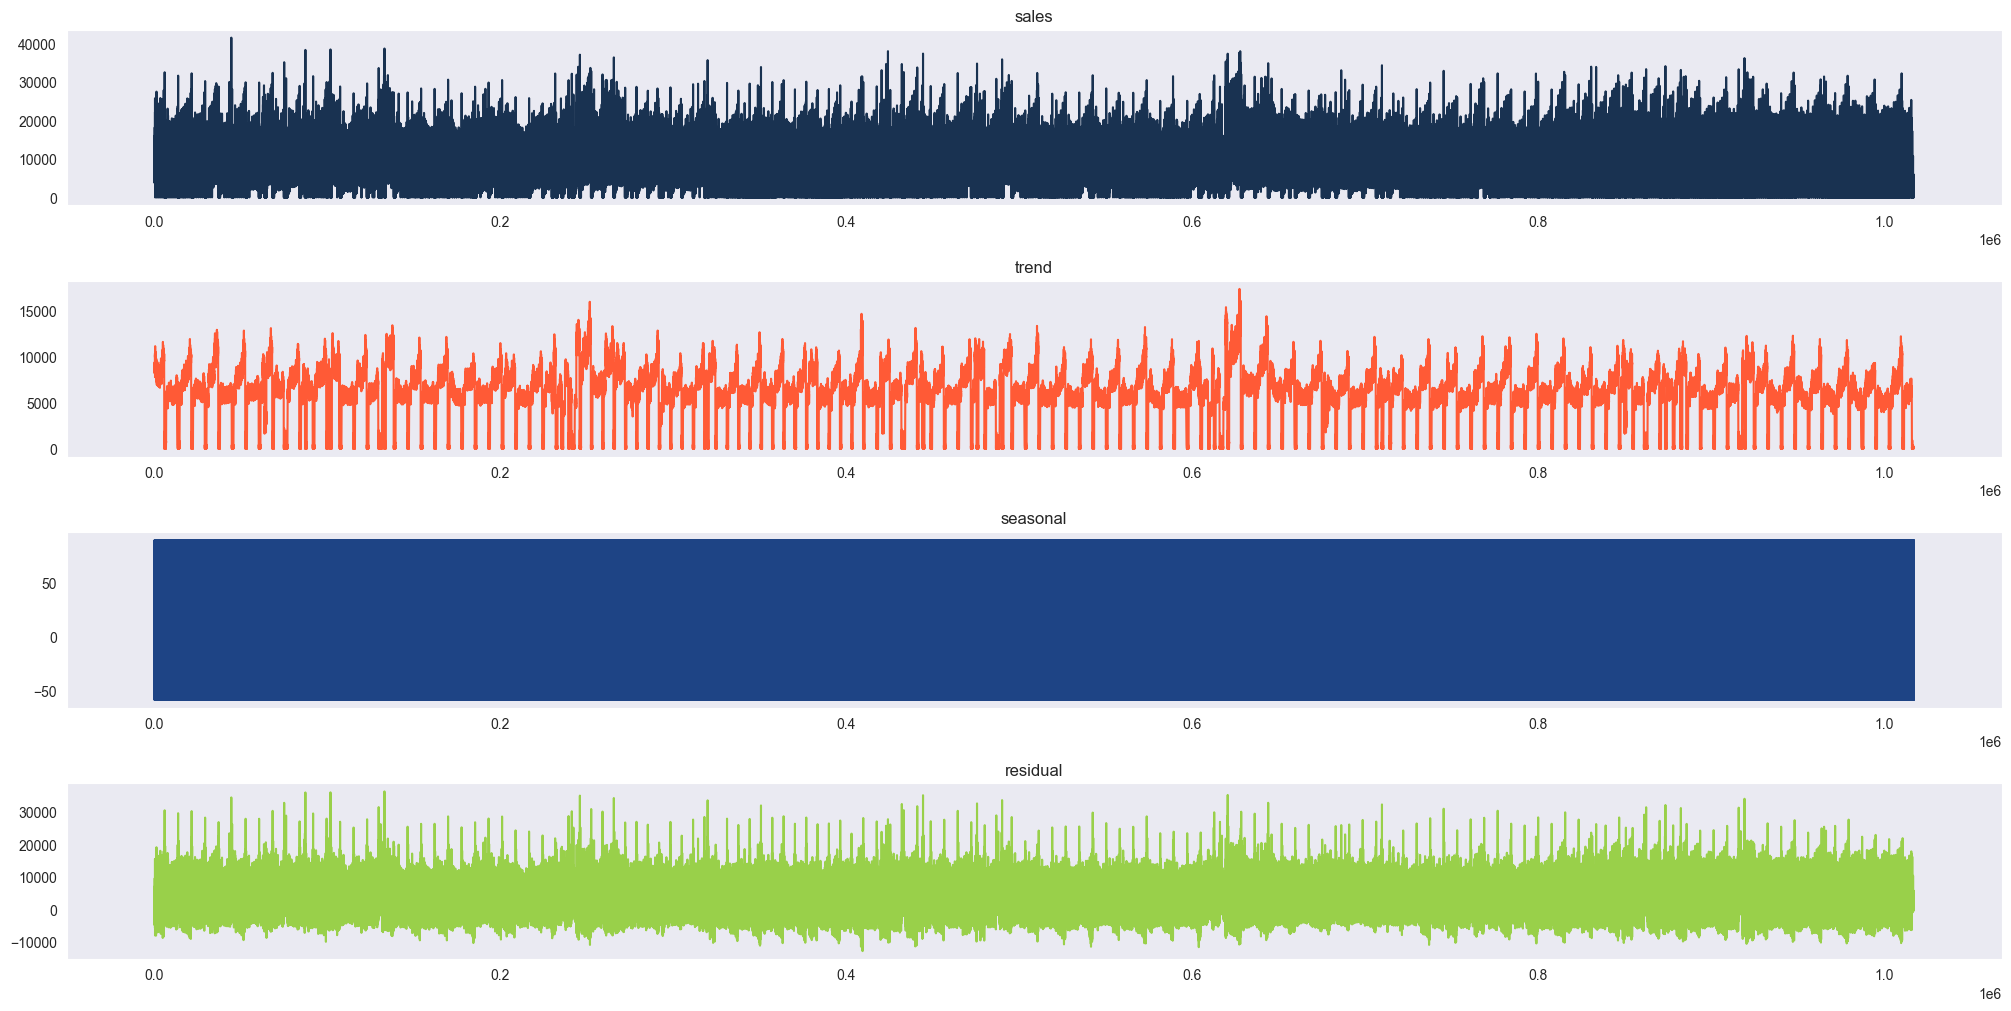

In [86]:
# Check decomposition of trend, seasonality and residue of original time series
decomposition = seasonal_decompose(x=df['sales'], 
                                   model='additive',
                                   period=30)


fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)
decomposition.observed.plot(c=sns_c[0], ax=ax[0])
ax[0].set(title='sales')
decomposition.trend.plot(c=sns_c[1], ax=ax[1])
ax[1].set(title='trend')
decomposition.seasonal.plot(c=sns_c[2], ax=ax[2])
ax[2].set(title='seasonal')
decomposition.resid.plot(c=sns_c[3], ax=ax[3])
ax[3].set(title='residual')
fig.set_size_inches(20, 10);

The trend experienced some ups and downs as a sales generally does. We can conclude that (it is not seasonal as) the seasonality doesn't give any clear picture.
The variance of the resiudals remain relatively constant.

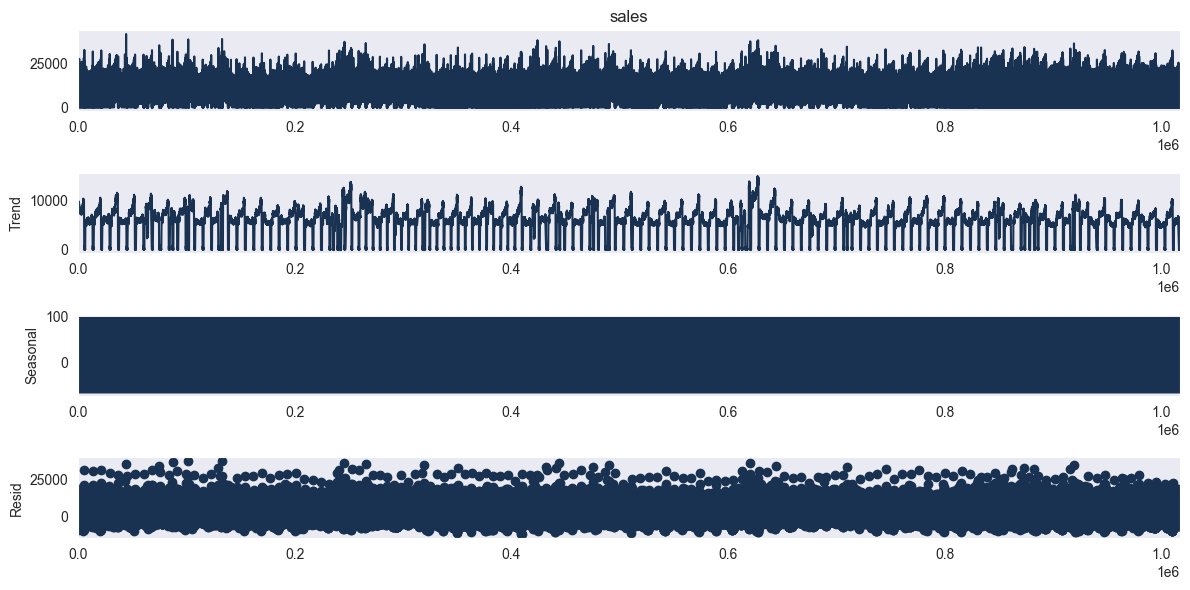

In [87]:
decomposition = sm.tsa.seasonal_decompose(x=df['sales'], model='additive',period = 100)
fig = decomposition.plot()
plt.show()


## De-trend the Time Series


# De-trending the time series
df['Sales_Detrend'] = (df['sales'] - df['sales'].shift(30))

# Test for stationarity after de-trending 
def stationarity_test(sales):
    
    # Calculate rolling mean and rolling standard deviation
    rolling_mean = sales.rolling(30).mean()
    rolling_std_dev = sales.rolling(30).std()
  
    # Plot the statistics
    plt.figure(figsize=(24,6))
    plt.plot(rolling_mean, label='Rolling Mean',linewidth=2.0)
    plt.plot(rolling_std_dev, label = 'Rolling Std Dev',linewidth=2.0)
    plt.plot(sales,label='De-Trended Time Series')
    plt.xticks([])
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.tight_layout()
    
    # ADF test
    print("ADF Test:")
    adf_test = adfuller(sales,autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('----'*10)
    
    # KPSS test
    print("KPSS Test:")
    kpss_test = kpss(sales, regression='c', nlags='legacy', store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print('----'*10)
    
stationarity_test(df['Sales_Detrend'].dropna())

 Partial Autocorrelation Plot
pacf = plot_pacf(df['Sales_Detrend'].dropna(), lags=30)

In [88]:
df_ts = df.drop(["date","stateholiday","storetype", "promointerval","assortment"],axis=1)

In [89]:
df_ts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 23 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   store                      1017209 non-null  int64         
 1   dayofweek                  1017209 non-null  int64         
 2   sales                      1017209 non-null  int64         
 3   customers                  1017209 non-null  int64         
 4   open                       1017209 non-null  int64         
 5   promo                      1017209 non-null  int64         
 6   schoolholiday              1017209 non-null  int64         
 7   competitiondistance        1017209 non-null  float64       
 8   competitionopensincemonth  1017209 non-null  float64       
 9   competitionopensinceyear   1017209 non-null  float64       
 10  promo2                     1017209 non-null  int64         
 11  promo2sinceweek            1017209 no

In [90]:
df_test.drop(["Date","StateHoliday"], axis=1 , inplace=True)

In [91]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Id                41088 non-null  int64         
 1   Store             41088 non-null  int64         
 2   DayOfWeek         41088 non-null  int64         
 3   Open              41088 non-null  int64         
 4   Promo             41088 non-null  int64         
 5   SchoolHoliday     41088 non-null  int64         
 6   timestamp         41088 non-null  datetime64[ns]
 7   year              41088 non-null  int64         
 8   month             41088 non-null  int64         
 9   day               41088 non-null  int64         
 10  dayofyear         41088 non-null  int64         
 11  StateHoliday_cat  41088 non-null  int64         
dtypes: datetime64[ns](1), int64(11)
memory usage: 3.8 MB


In [92]:
df_test["timestamp"].max()

Timestamp('2015-09-17 00:00:00')

In [93]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Id                41088 non-null  int64         
 1   Store             41088 non-null  int64         
 2   DayOfWeek         41088 non-null  int64         
 3   Open              41088 non-null  int64         
 4   Promo             41088 non-null  int64         
 5   SchoolHoliday     41088 non-null  int64         
 6   timestamp         41088 non-null  datetime64[ns]
 7   year              41088 non-null  int64         
 8   month             41088 non-null  int64         
 9   day               41088 non-null  int64         
 10  dayofyear         41088 non-null  int64         
 11  StateHoliday_cat  41088 non-null  int64         
dtypes: datetime64[ns](1), int64(11)
memory usage: 3.8 MB


In [94]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 15 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   Store             1017209 non-null  int64         
 1   DayOfWeek         1017209 non-null  int64         
 2   Date              1017209 non-null  object        
 3   Sales             1017209 non-null  int64         
 4   Customers         1017209 non-null  int64         
 5   Open              1017209 non-null  int64         
 6   Promo             1017209 non-null  int64         
 7   StateHoliday      1017209 non-null  object        
 8   SchoolHoliday     1017209 non-null  int64         
 9   timestamp         1017209 non-null  datetime64[ns]
 10  year              1017209 non-null  int64         
 11  month             1017209 non-null  int64         
 12  day               1017209 non-null  int64         
 13  dayofyear         1017209 non-null  int64 

In [95]:
train_data= train_data.drop(["Date","StateHoliday"], axis=1)

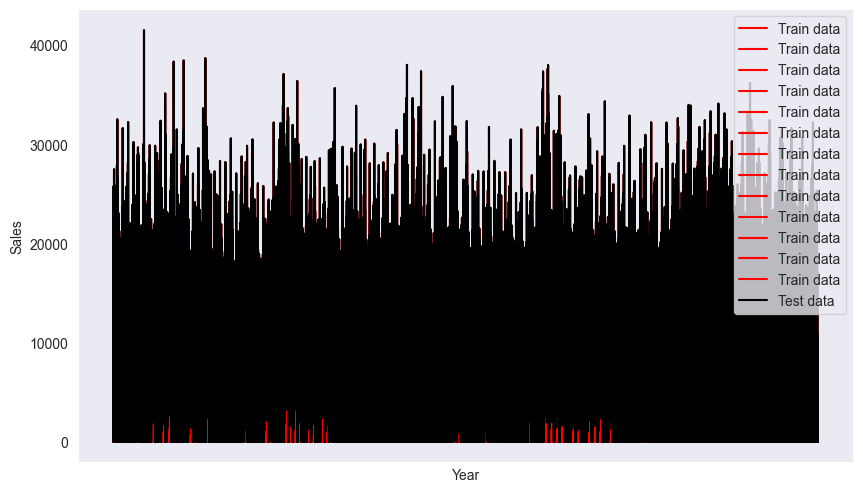

In [96]:

# Split data into train and test set
df_arima = df_ts['sales']


# Plotting the train and test set
plt.figure(figsize=(10,6))
plt.xlabel('Year')
plt.ylabel('Sales')
plt.xticks([])
plt.plot(train_data, 'red', label='Train data')
plt.plot(df_arima, 'black', label='Test data')
plt.legend();

In [97]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Id                41088 non-null  int64         
 1   Store             41088 non-null  int64         
 2   DayOfWeek         41088 non-null  int64         
 3   Open              41088 non-null  int64         
 4   Promo             41088 non-null  int64         
 5   SchoolHoliday     41088 non-null  int64         
 6   timestamp         41088 non-null  datetime64[ns]
 7   year              41088 non-null  int64         
 8   month             41088 non-null  int64         
 9   day               41088 non-null  int64         
 10  dayofyear         41088 non-null  int64         
 11  StateHoliday_cat  41088 non-null  int64         
dtypes: datetime64[ns](1), int64(11)
memory usage: 3.8 MB


In [98]:
# Autocorrelation function to make ACF and PACF graphs
def auto_corr(sales):
    lag_acf = acf(sales,nlags=30)
    lag_pacf = pacf(sales,nlags=20,method='ols')
  
    plt.subplot(121)
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color ='red')
    plt.axhline(y=1.96/np.sqrt(len(sales)),linestyle='--',color ='red')
    plt.axhline(y=-1.96/np.sqrt(len(sales)),linestyle='--',color ='red')
    plt.title('ACF')
    
    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color ='red')
    plt.axhline(y=1.96/np.sqrt(len(sales)),linestyle='--',color ='red')
    plt.axhline(y=-1.96/np.sqrt(len(sales)),linestyle='--',color ='red')
    plt.title('PACF')

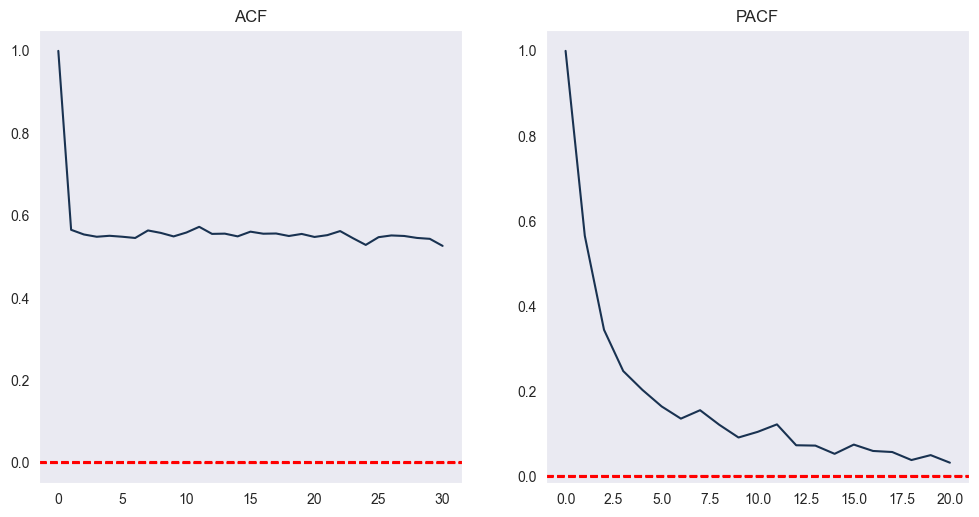

In [90]:
# ACF and PACF for sales
auto_corr(df["sales"])

Due to their opposite behavior for AR and MA processes, a combination of ACF and PACF plots can be used to identify both p and q for an ARMA process.
In such a case, the PACF identifies p and ACF identifies the q order of the ARMA process.

In [91]:
df_test

Id  Store  DayOfWeek  Open  Promo  SchoolHoliday  timestamp  year  \
0          1      1          4     1      1              0 2015-09-17  2015   
1          2      3          4     1      1              0 2015-09-17  2015   
2          3      7          4     1      1              0 2015-09-17  2015   
3          4      8          4     1      1              0 2015-09-17  2015   
4          5      9          4     1      1              0 2015-09-17  2015   
...      ...    ...        ...   ...    ...            ...        ...   ...   
41083  41084   1111          6     1      0              0 2015-08-01  2015   
41084  41085   1112          6     1      0              0 2015-08-01  2015   
41085  41086   1113          6     1      0              0 2015-08-01  2015   
41086  41087   1114          6     1      0              0 2015-08-01  2015   
41087  41088   1115          6     1      0              1 2015-08-01  2015   

       month  day  dayofyear  StateHoliday_cat  
0          9   17        260                 0  
1          9   17        260                 0  
2          9   17        260                 0  
3          9   17        260                 0  
4          9   17        260                 0  
...      ...  ...        ...               ...  
41083      8    1        213                 0  
41084      8    1        213                 0  
41085      8    1        213                 0  
41086      8    1        213                 0  
41087      8    1        213                 0  

[41088 rows x 12 columns]

In [91]:
df_train.head(20)

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0       1          5  2015-07-31   5263        555     1      1            0   
1       2          5  2015-07-31   6064        625     1      1            0   
2       3          5  2015-07-31   8314        821     1      1            0   
3       4          5  2015-07-31  13995       1498     1      1            0   
4       5          5  2015-07-31   4822        559     1      1            0   
5       6          5  2015-07-31   5651        589     1      1            0   
6       7          5  2015-07-31  15344       1414     1      1            0   
7       8          5  2015-07-31   8492        833     1      1            0   
8       9          5  2015-07-31   8565        687     1      1            0   
9      10          5  2015-07-31   7185        681     1      1            0   
10     11          5  2015-07-31  10457       1236     1      1            0   
11     12          5  2015-07-31   8959        962     1      1            0   
12     13          5  2015-07-31   8821        568     1      1            0   
13     14          5  2015-07-31   6544        710     1      1            0   
14     15          5  2015-07-31   9191        766     1      1            0   
15     16          5  2015-07-31  10231        979     1      1            0   
16     17          5  2015-07-31   8430        946     1      1            0   
17     18          5  2015-07-31  10071        936     1      1            0   
18     19          5  2015-07-31   8234        718     1      1            0   
19     20          5  2015-07-31   9593        974     1      1            0   

    SchoolHoliday  
0               1  
1               1  
2               1  
3               1  
4               1  
5               1  
6               1  
7               1  
8               1  
9               1  
10              1  
11              1  
12              0  
13              1  
14              1  
15              1  
16              1  
17              1  
18              1  
19              0

# Auto ARIMA Method
arima_model = auto_arima(df_arima,
                      random=True,
                      test='adf',        
                      trace=True,
                      alpha=0.05,
                      scoring='mse',
                      suppress_warnings=True,
                      seasonal = True,
                      stationary= True,
                         n_jobs=-1
                      
                      )



# Fit the final model with the order
fitted_model = arima_model.fit(df_ts) 
print(fitted_model.summary())

# Forecasting values
forecast_values = fitted_model.predict(len(df_ts), alpha=0.05) 
fcv_series = pd.Series(forecast_values[0], index=test_data.index)

# Plot the predicted stock price and original price
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_ts, label='training')
plt.plot(df_test, label='Actual Sales ')
plt.plot(fcv_series,label='Predicted Sales')
plt.title('Sales Prediction')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.xticks([])
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Evaluate the model by calculating RMSE
rms_auto_arima = sqrt(mean_squared_error(df_test.values, fcv_series))
print("Auto-Arima RMSE :- " + str(round(rms_auto_arima,3)))

In [ ]:
# Prophet

In [103]:
df_ts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 23 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   store                      1017209 non-null  int64         
 1   dayofweek                  1017209 non-null  int64         
 2   sales                      1017209 non-null  int64         
 3   customers                  1017209 non-null  int64         
 4   open                       1017209 non-null  int64         
 5   promo                      1017209 non-null  int64         
 6   schoolholiday              1017209 non-null  int64         
 7   competitiondistance        1017209 non-null  float64       
 8   competitionopensincemonth  1017209 non-null  float64       
 9   competitionopensinceyear   1017209 non-null  float64       
 10  promo2                     1017209 non-null  int64         
 11  promo2sinceweek            1017209 no

In [110]:
df_prophet = df_ts.drop(["salepercustomer","stateholiday_cat","storetype_cat","ass_extended","ass_extra", \
                         "dayofyear","day","month","year","promo2sinceyear","promo2sinceweek","promo2","competitionopensinceyear", \
                         "competitionopensincemonth","competitiondistance","schoolholiday","promo","open","customers","dayofweek","store"],axis=1)

In [120]:
df_prophet.columns = ["y","ds"]

In [141]:
df_prophet.tail(30)

y         ds
1017179     0 2013-01-01
1017180     0 2013-01-01
1017181     0 2013-01-01
1017182     0 2013-01-01
1017183     0 2013-01-01
1017184     0 2013-01-01
1017185     0 2013-01-01
1017186     0 2013-01-01
1017187     0 2013-01-01
1017188     0 2013-01-01
1017189     0 2013-01-01
1017190  5961 2013-01-01
1017191     0 2013-01-01
1017192     0 2013-01-01
1017193     0 2013-01-01
1017194     0 2013-01-01
1017195     0 2013-01-01
1017196     0 2013-01-01
1017197     0 2013-01-01
1017198     0 2013-01-01
1017199     0 2013-01-01
1017200     0 2013-01-01
1017201     0 2013-01-01
1017202     0 2013-01-01
1017203     0 2013-01-01
1017204     0 2013-01-01
1017205     0 2013-01-01
1017206     0 2013-01-01
1017207     0 2013-01-01
1017208     0 2013-01-01

In [162]:
m =Prophet(interval_width=0.8)

In [163]:
model_prophet= m.fit(df_prophet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [164]:
future_sales= m.make_future_dataframe(periods=48)
forecast_sales= m.predict(future_sales)
forecast_sales.head(10)

ds        trend   yhat_lower    yhat_upper  trend_lower  \
0 2013-01-01  6055.133192  2295.274837   9914.822763  6055.133192   
1 2013-01-02  6051.903386  1909.118208   9441.797682  6051.903386   
2 2013-01-03  6048.673580  1600.589545   9357.539789  6048.673580   
3 2013-01-04  6045.443774  2041.781865   9644.060022  6045.443774   
4 2013-01-05  6042.213968  1137.351688   8831.943545  6042.213968   
5 2013-01-06  6038.984162 -4738.688310   3183.378595  6038.984162   
6 2013-01-07  6035.754355  3155.059057  10962.914527  6035.754355   
7 2013-01-08  6032.524549  2520.742263   9973.511599  6032.524549   
8 2013-01-09  6029.294743  1574.650617   9682.507348  6029.294743   
9 2013-01-10  6026.064937  1865.106522   9682.307304  6026.064937   

   trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0  6055.133192      110.997627            110.997627            110.997627   
1  6051.903386     -375.428696           -375.428696           -375.428696   
2  6048.673580     -708.016172           -708.016172           -708.016172   
3  6045.443774     -245.078103           -245.078103           -245.078103   
4  6042.213968    -1118.847594          -1118.847594          -1118.847594   
5  6038.984162    -6752.696272          -6752.696272          -6752.696272   
6  6035.754355      871.983264            871.983264            871.983264   
7  6032.524549      103.155110            103.155110            103.155110   
8  6029.294743     -309.234596           -309.234596           -309.234596   
9  6026.064937     -573.747330           -573.747330           -573.747330   

        weekly  weekly_lower  weekly_upper       yearly  yearly_lower  \
0  1237.085790   1237.085790   1237.085790 -1126.088163  -1126.088163   
1   786.659222    786.659222    786.659222 -1162.087918  -1162.087918   
2   477.604580    477.604580    477.604580 -1185.620752  -1185.620752   
3   951.902383    951.902383    951.902383 -1196.980486  -1196.980486   
4    77.835335     77.835335     77.835335 -1196.682928  -1196.682928   
5 -5567.248278  -5567.248278  -5567.248278 -1185.447994  -1185.447994   
6  2036.160969   2036.160969   2036.160969 -1164.177705  -1164.177705   
7  1237.085790   1237.085790   1237.085790 -1133.930680  -1133.930680   
8   786.659222    786.659222    786.659222 -1095.893818  -1095.893818   
9   477.604580    477.604580    477.604580 -1051.351910  -1051.351910   

   yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
0  -1126.088163                   0.0                         0.0   
1  -1162.087918                   0.0                         0.0   
2  -1185.620752                   0.0                         0.0   
3  -1196.980486                   0.0                         0.0   
4  -1196.682928                   0.0                         0.0   
5  -1185.447994                   0.0                         0.0   
6  -1164.177705                   0.0                         0.0   
7  -1133.930680                   0.0                         0.0   
8  -1095.893818                   0.0                         0.0   
9  -1051.351910                   0.0                         0.0   

   multiplicative_terms_upper         yhat  
0                         0.0  6166.130819  
1                         0.0  5676.474689  
2                         0.0  5340.657408  
3                         0.0  5800.365671  
4                         0.0  4923.366374  
5                         0.0  -713.712111  
6                         0.0  6907.737619  
7                         0.0  6135.679659  
8                         0.0  5720.060147  
9                         0.0  5452.317607

def rmspe(y_true, y_pred):
    return np.sqrt(np.nanmean(np.square(((y_true - y_pred) / y_true))))*100

In [165]:
def rmse(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays.
    '''
    loss = np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true)), axis=0))

    return loss

In [166]:
rmse(df_arima,forecast_sales["yhat"])

inf

In [147]:
def rmspe(y_true, y_pred):
    return np.sqrt(np.nanmean(np.square(((y_true - y_pred) / y_true))))*100

In [148]:
rmse(df_arima,forecast_sales["yhat"])

inf

In [153]:
def rmspe(y, y_hat):
    return np.sqrt(np.mean(((y - y_hat) / y) ** 2))

In [154]:
rmspe(df_arima,forecast_sales["yhat"])

inf

In [160]:
#Define the evaluation function, you can pass in the loss function of the replacement model itself in the later model
def rmspe(y,yhat):
    return np.sqrt(np.mean((yhat/y-1)**2))

def rmspe_xg(yhat,y):
    y=np.expm1(y.get_label())
    yhat=np.expm1(yhat)
    return 'rmspe',rmspe(y,yhat)



In [161]:
rmspe(df_arima,forecast_sales["yhat"])

inf